In [1]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
import lightgbm as lgb

import multiprocessing
from multiprocessing import Pool, Manager

import pickle
import math
import gc
import psutil

pd.set_option("display.max_columns", 100)

In [2]:
# Settings and altering components for GCP

# path settings
root_path = "../input/indoor-location-navigation/"
# root_path = "../jupyter/input/"
train_paths = glob.glob(root_path + "train" + "/*/*/*")
test_paths = glob.glob(root_path + "test" + "/*")
metafiles = glob.glob(root_path + "metadata" + "/*")

# function imports using github repo in kaggle kernels
# https://www.kaggle.com/getting-started/71642
!cp -r ../input/indoorlocationcompetition20master/indoor-location-competition-20-master/* ./
from io_f import read_data_file
from compute_f import compute_step_positions, compute_steps, \
compute_headings, compute_stride_length, compute_step_heading, compute_rel_positions, split_ts_seq

# import for gcp settings
# import compute_f
# import io_f
# import visualize_f
# import main
# from io_f import read_data_file
# from compute_f import compute_step_positions, compute_steps, \
# compute_headings, compute_stride_length, compute_step_heading, compute_rel_positions, split_ts_seq

In [77]:
# filter milisecond setting 
IMU_CUT = 250
WPS_CUT = 5000

# train number setting
# TRAIN_NUM = len(train_paths)
# TRAIN_NUM = round(len(train_paths) / 2)
TRAIN_NUM = 10

# floor translation
FLOOR_MAP = {"B3":-3,"B2":-2,"B1":-1,"F1":0,"1F":0,"F2":1,"2F":1,"F3":2,"3F":2,"F4":3,"4F":3,
             "F5":4,"5F":4,"F6":5,"6F":5,"F7":6,"7F":6,"F8":7,"8F": 7,"F9":8,"9F":8,"F10":9,
             "B":0,"BF":1,"BM":2, "G":0, "M":0, "P1":0,"P2":1, "LG2":-2,"LG1":-1,"LG":0,"LM":0,
             "L1":1,"L2":2,"L3":3,"L4":4,"L5":5,"L6":6,"L7":7,"L8":8,"L9":9,"L10":10,"L11":11}

# Columns to shift to the beginning of df
SHIFT_COLS = ["acce_z_avg", "acce_y_avg", "acce_x_avg", \
              "site_id", "file_id", "floor_int", "floor", \
              "y", "x", "wps_diff", "wifi_ts"]

In [4]:
# Preprocess
print("No. Files in Train: {:,}".format(len(train_paths)), "\n" +
      "No. Files in Test: {:,}".format(len(test_paths)), "\n" +
      "No. of metadata files: {:,}".format(len(metafiles)))

# Reading in 1 file
def pick_example(max_range, paths):
    ex = random.randint(0, max_range)
    example_path = paths[ex]
    path = f"{example_path}"
    paths = path.split("/")
    site = paths[4]
    floorNo = paths[5]
    floor_plan_filename = f"{root_path}metadata/{site}/{floorNo}/floor_image.png"
    json_plan_filename = f"{root_path}metadata/{site}/{floorNo}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]
    return path, site, floorNo, floor_plan_filename, json_plan_filename, width_meter, height_meter

path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
print("example path: ", path)
print("site: ", site)
print("floorNo: ", floorNo)
print("floor_plan_filename: ", floor_plan_filename)
print("json_plan_filename: ", json_plan_filename)
print("width: {}, height: {} ".format(width_meter, height_meter))

with open(path) as p:
    lines = p.readlines()
print("No. Lines in 1 example: {:,}". format(len(lines)))

No. Files in Train: 26,925 
No. Files in Test: 626 
No. of metadata files: 204
example path:  ../input/indoor-location-navigation/train/5cd56b96e2acfd2d33b5ef8f/F4/5cf4ff40d1378b00092687a0.txt
site:  5cd56b96e2acfd2d33b5ef8f
floorNo:  F4
floor_plan_filename:  ../input/indoor-location-navigation/metadata/5cd56b96e2acfd2d33b5ef8f/F4/floor_image.png
json_plan_filename:  ../input/indoor-location-navigation/metadata/5cd56b96e2acfd2d33b5ef8f/F4/floor_info.json
width: 85.33926893255835, height: 53.767330378348625 
No. Lines in 1 example: 20,977


In [5]:
# for line in lines:
#     print(line)

In [6]:
# Redefine the data extraction class

from dataclasses import dataclass

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file_ed(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, '_'.join([ssid, bssid]), rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            txpower = line_data[5]
            rssi = line_data[6]
            distance = line_data[7]
            mac_address = line_data[-2]
            beacon_ts = line_data[-1]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), txpower, rssi, distance, mac_address, beacon_ts]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [8]:
# Find out how many wps datapoints and wifi datapoints one floor has
train_path_floor = glob.glob(root_path + "train" + "/*/*/")
# train_paths = glob.glob(root_path + "train" + "/*/*/*")
ex = random.randint(0, 6)
print(train_path_floor[ex])
print("no. of files of that floor: ", len(os.listdir(train_path_floor[ex])))
count = 0
for f in os.listdir(train_path_floor[ex]):
    file_path = train_path_floor[ex] + f
    data = read_data_file_ed(file_path)
    count += len(data.waypoint)
    
print(count)

../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/F3/
no. of files of that floor:  6
32


In [61]:
# path, site, floorNo, floor_plan_filename, json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
# show_site_png(root_path, site=site)

In [9]:
# Feature candidate
# You can't get the waypoint in test, so use acce and ahrs data to calculate relative positions
def calc_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    # only use del if we don't need timestamps
    # rel_positions_del = np.delete(rel_positions, 0, 1)
    return rel_positions

# Feature candidate
# Modify extract_magnetic_strength from github for one magnetic data point
def extract_one_magn_strength(magn_datas):
    d = np.array(magn_datas[2:5])
    return np.mean(np.sqrt(np.sum(d ** 2, axis=0)))

In [10]:
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)

In [81]:
# Common methods
def extract_nearest_wps(wps_data, wifi_ts):
    wps_ts = wps_data[:, 0].astype(int)
    diff_list = []
    for ts in wps_ts:
        diff = abs(int(wifi_ts) - ts)
        diff_list.append(diff)
    diff_idx = np.argmin(diff_list)
    return diff_list[diff_idx], wps_data[diff_idx]

def extract_imu_rep(imu_data, wifi_ts):
    imu_ts = imu_data[:, 0].astype(int)
    diff_list = []
    for ts in imu_ts:
        diff = abs(int(wifi_ts) - ts)
        diff_list.append(diff)
    # diff_idx = np.argmin(diff_list)
    # acce_diff_range = [(i,a) for i, a in enumerate(diff_list) if a < cut_line] # uncomment if we need to check acce_diff
    acce_diff_range = [i for i, a in enumerate(diff_list) if a < IMU_CUT]
    # print(len(acce_diff_range))
    imu_filtered = imu_data[acce_diff_range]
    # print(int(wifi_ts))
    # print(imu_filtered[:, 0].astype(int)) # Check if it's taking 250ms acce correctly
    # print(imu_filtered)
    # print(imu_filtered[:, 1]) # Check if we're taking x values correctly
    imu_avg_x = imu_filtered[:, 1].mean()
    imu_avg_y = imu_filtered[:, 2].mean()
    imu_avg_z = imu_filtered[:, 3].mean()
    #print(imu_avg_x, imu_avg_y, imu_avg_z)
    return imu_avg_x, imu_avg_y, imu_avg_z

def shift_columns(cols, df):
    for col in cols:
        df_cols = list(df.columns)
        df_cols.insert(0, df_cols.pop(df_cols.index(col)))
        df = df[df_cols]
    return df

---
## Train generator
---

In [ ]:
# Train specific methods

def extract_train_path(path):
    try:
        ex_path = f"{path}"
        ex_paths = ex_path.split("/")
        site_id = ex_paths[4]
        floor = ex_paths[5]
        f = FLOOR_MAP[floor]
        file_id = ex_paths[6].split(".")[0]
        return site_id, file_id, f, floor
    except:
        print("extract_path error")

def make_wifi_df_train(path):
    # First path
    datas = read_data_file_ed(path)
    acce_datas = datas.acce
    magn_datas = datas.magn
    ahrs_datas = datas.ahrs
    wifi_datas = datas.wifi
    ibeacon_datas = datas.ibeacon
    wps = datas.waypoint # not to be used

    # acce and ahrs data translation
    # rel_positions = calc_rel_positions(acce_datas, ahrs_datas)

    # print("wifi unique ts len: ", len(set(wifi_datas[:, 0])))

    # Make wifi df with wifi_ts
    dfs = []
    df = pd.DataFrame(wifi_datas[:,[0,2,4]])
    for wifi_ts, g in df.groupby(0):
        g = g.drop_duplicates(subset=1)
        tmp = g.iloc[:,1:]
        feat = tmp.set_index(1).T
        feat["wifi_ts"] = wifi_ts

        # get closest wps
        closest_wps = extract_nearest_wps(wps, wifi_ts)
        feat["wps_diff"] = closest_wps[0]
        feat["x"] = closest_wps[1][1]
        feat["y"] = closest_wps[1][2]
        
        # get average of acce within 250ms
        acce_avgs = extract_imu_rep(acce_datas, wifi_ts)
        feat["acce_x_avg"] = acce_avgs[0]
        feat["acce_y_avg"] = acce_avgs[1]
        feat["acce_z_avg"] = acce_avgs[2]
        
        # get floor and other path data
        site_id, file_id, f, floor = extract_train_path(path)
        feat["site_id"] = site_id
        feat["file_id"] = file_id
        feat["floor_int"] = f
        feat["floor"] = floor
        
        dfs.append(feat)
    
    return dfs


def make_train_df(paths_df, building_list):
    for building in building_list:
        df = paths_df[paths_df["site_id"] == building]
        paths = df["path"].unique()
        dfs_all = pool.map(make_wifi_df_train, tqdm(paths))
        dfs_unpack = [row for df in dfs_all for row in df]
        wifi_df = pd.concat(dfs_unpack)
        shift_columns(SHIFT_COLS, wifi_df)
        wifi_df.to_csv(f"{building}_train.csv", index=False)
        del wifi_df

In [ ]:
# train_path filtering

def extract_path_for_grouplist(path):
    ex_path = f"{path}"
    ex_paths = ex_path.split("/")
    site_id = ex_paths[4]
    file_id = ex_paths[6].split(".")[0]
    return [path, site_id, file_id]

# create pathlist to be used by 2 types of paths list
path_list = [extract_path_for_grouplist(item) for item in train_paths]
df_paths = pd.DataFrame(path_list, columns=["path", "site_id", "file_id"])
site_id_path_list = df_paths["site_id"].unique()

# grouped_paths_list -> It takes 3 records from every site_id
grouped_paths_df = df_paths.groupby("site_id").sample(n=3)
grouped_paths_list = list(grouped_paths_df["path"].unique())
display(grouped_paths_df.head())

In [16]:
start = time.time()
num_cores = multiprocessing.cpu_count()
pool = Pool(num_cores)

# Set training files
grouped_paths_df = grouped_paths_df.iloc[:9,:]
train_building_list = grouped_paths_df["site_id"].unique()

# Run generator
make_train_df(grouped_paths_df, train_building_list)

print("time to extract data: ", time.time() - start)
pool.close()

100%|██████████| 3/3 [00:00<00:00, 3628.29it/s]


5a0546857ecc773753327266
51


1,9ba60f32fb62a821c768182f6a4e69ffd9d0939e,cb1e0bae14b56a66bdf073310736fc4ff281046d,1c8e3ea2ec9808edfe25e8c3eb6fb2ee4bfd7c16,bbf1e71834f60885aacf4d9f187242f7dd990437,9000e885278b235609922c0b8ad8a558734214d6,00f0904087c01d922d6ebf3005607dfdeaf6687b,f27b6603820d90e9b0ee05949273d6059e6b5170,0c4130e1e769677a016612b48d96480a8cdd1dc4,c236cb5a525430ecff488e4f496408d7cd8aac91,661ef3ef6c6c03d166a083e05ad508dfb3c20d72,0a670fddca113cc7a87dbadd903190dd6d22c75d,e6da08a7a45bef7bcd5c74a4f13243dcf55d4d92,b42376db2f3421b282eaa7a344545193b1e41a92,36e6b156d1ef43e2e3a385574302b62c6ba890a2,93dcf9f3ffa932065ec1e7391cfd87afd1ad1374,fadd8651e9da3c6eaf9d130ba80c45999e69decf,d9646fe8eaa15e9e8f785c77324fa811e48df081,9c472f9c7acf424f2ca0242d5c2dd4cfc083b8be,9e1cbe20926f9883262826bc764ff872d80c53ab,2e88627bafac16a05c44723624ac89e19ace9f9a,246222328f56331300113e7da7eac1ae805040d7,06aed0ed92794f30f58f2991e09e62bc01434362,6348dc6f36e47858ed067cbd55e67bf5df721058,2e5db380194ac208177bdbdc28e5b2c84b48be14,7a10fbc53a85f75ecc384b48a9fe5cc3f6b1cc74,ef018fe92940aff5b1024ea2d5d217586b8b0657,00af060fc145ee6a6a50475efa57b91cbf54237f,bab518dcd363ffabaa102e752d4bf954f8215f72,c1023eac917a0a67930add5bf24fbfc7bb9eb5f2,e541767087b8a83879c2af29dc21fe7a308886b4,32e4d3e636293aef4f3cc572d0c4e0532e907bde,30ff46262a48e2a6161019d64d790cf19e19dd53,c9f41cb33bf95e1f44c59ccc41011eaeb2dadfca,13cd1e6a6af504e46baff3e4ebf4084566a55272,62c80c57dc1147cab98d7589b781ed5e5ecc1a37,500f56d1499008047d41c74dc7f5b81de763e901,0b5f69e5bbfd1cd46da3b29afd1d674c0925c2ab,36c724fbf6ad6ec9bc344eb294d7ccaab6a0ac89,4144e570688dc3c06087856f34df24f8ec7c9ee9,c90cd4db681cc113a5a4ccb983e36ce767e7c8f3,b550acc32dcc2b1726425312c5bfe19805047b39,296ea9e41acd823ca04a211edefa7cc6457728a4,82d03402cffaacc2c1a738f1cd11ef8768c0b922,a6e2eb6f1e138c7da99b2f2b8b90ceee71f19590,4e9e62dc67a0ab626e381b4b597c85036474686f,7dfce685350a56059c6f213bebda6d3ef8e06a7b,f79914f6e6857983f2ff1aae5726102534ba9000,1477e2804baeafbd9bee7bb329bd44359af70b35,7a22352c28d653936a6a38916ec5692fe128927b,843620e0e07486017d7d75613802cc3f9030e0d2,...,e2a7123759cacf81363159e801826cff200dd3dd,9e5f238cf72429621eb8449634b9af8a3e85db6e,1100e7292bb71bf064a85907d5e8fdb87e85e27e,e667c1dba1fa5fa29c7e69a337fbd728a930d703,b1f52858bbf18f942f355bd4974f2c931125d135,d8d94ed75e4f2082de96d21f811f3bafd2a8d67c,db01605eac3f33540038bd9722aba25774871d43,5e659698b697f5fa0759dcb9cb42e557ca80f09e,3f564032c7eebc173b38aee35225e323d4389faf,e57024faa1bfe6de5d71e1b779bff11e72e97e1d,add8b64585688391c11f2e0d1ca9039b70c802e5,5c10b343d767a30515e6015de25751a2883328f8,f26678bbbbd078e242638a0d1fb5ba2e61262f4c,99ef5e3c5b2ba528f8cd5c7534e28544c866fa1e,569878b7f574a738d49e365f45c49f44b81936f2,9fae059a2742b7f8b9a2caad61749d106b4787f6,c8f3983a40e3c462cdfd155f3d0c77868a717ffd,f3be6e417e86b9791b18d17894f98fb882883099,76f81d5047273fa64a434457531d400fc5d90fac,6e388d1db5ba8dd9de80522a4ddf50402cf443b3,ceccac4f0e50ec9e36e8d2800b8f2c7c3b4d903e,58d88c1d4ba920fdc3707030403c6c3baef4b8a1,a3871bcf1178a37b8928464f49f4c548e675c249,1b2fd184314ae440900fa9ce1addeb896b5604a9,4a92bcc3cf0cdb4d531ec140ef5b4d9d0898d7fd,78263f1b65e22aed4750fe3690f95ec60193ef72,2c09230bb32ee49f6a72928f6eeefb6885dc15ce,1ff45e1798b4a0950870d505aa00b5add7915e03,a367e4b58bbc0b6630cfe725260de764422afe1e,b56a7451fdebfe986a4a17414a9b289161e4dc50,463f6a61830c5982b9e20c857811212659ec2410,de381736cca568378a42b394952afe8bfa0691e9,2253c6a0d0f7277737aa8e86e0484be805124806,be0bf3206752bd57075bb6d382a9a90df6c72318,9e6c6ea99d2f707a29284c9eea06d17d4db84354,22af5f668c86451c027a6d670d40611cbabe2f1b,ee9c9078fdce9b99d80fee62dd5625fe4f80c72d,2daa7fde27c0fd44e4a0133c3247be06d3c21c0b,8b344975ccd0d427da6770c831c69f88ad0c0398,b5ae5dd4cd8ed6d46d5c903021436548aa36bd0b,a830915240b76b1da7286b938f5178b244d29b29,149c09a117b9851201c75f97b4a7cc94b75fdcb4,08f7de5409dd4c4df92a9be0e8daebc871d3e7d1,b620c25dbe4c7f1d4e05a197d16adef63da0f015,2c7c7e291b5bff74a842190246801e83069fd798,8c936564ea4b4300576f53136505527eb5972c07,599fa96d549ed870671d6bc1927aaa8bbaacca12,b2b0ddbb5a2aadfc6

100%|██████████| 3/3 [00:00<00:00, 6849.71it/s]

mode: train


5c3c44b80379370013e0fd2b
91


1,3c118f913b77a43be52ac3d885297ee3068dbc8e,e141d6ef577eb54b4e589dd2e3a2c43e89401321,11e6864f1a17b6d923867b1730b21fcf3efba5f9,ead8a9e6450aa75bb5ed3586251cb3e68641fa4a,fdba8f8ae00d07494ff16de862b6c402d4b17f02,babe266e8d3f1f5e327bd49c33c2061445d2627c,6263a30c2a272b57290c1115157057d5ba11dd1e,d4b358ab9f536543d3663942808e8500789b73a1,52d25eef64b26edeccfc2e5a58885a2417452715,b99d68ead9816b8101492ff09641521ee4756665,ca04032e95b9f47cfad2335f641125ef290bec5f,57dff60b2933fd182e2b08435846e2fc1b3f4055,dfee108491d3f2cfdc4f3a22dd6576a9aaa23dd2,71e84a7ceaee913f2284c266075500a0fbcda262,a683811bb6b9409bafaf886a3abc5db32e12cf0f,1d47f0a322dcde484b263509b8f901fe2b54126e,9705967b98e9c72b77aa54f5882e651149da9aa9,086d1848ddf93a031ed5c9394ac3fe2ab016ec28,dc8175920007b18e51adacd8956c06b6d12905ee,3fa839d2298c05ab2a59a9f1f1a9a46b8d85d4b3,44fb48ad1d73a664a77d3e398905c2bd32a7ace2,8435388eb6f5852d6f15149c0c0562d41654582d,46ff7fd07d7ad6966de7b201a2994f24d5ee093f,186276a28ee257c310a1a37623f7f165135c5398,720a0f23e64a82320673e9e72e32a674433e96f1,ee5c52f78efb347bb3777a4f629b9cc8a2dabc3d,a81ad3eed07f98a6b212f5854bd580c2616e04d2,1d28eaa0ccbb98cb829fb8240fefca25b9ad64ce,6596a525aa1385634ec9b50b147c185d42d097c4,11bbd5bd1485bcfbff9a41efae79df020e51670f,b1656024b9c7bb92674e9e99a2bcf9e44d20fcf4,951805210ab473b1cdee938ed06001dfe87b1b97,f11ce4136c58148694ec8fec04b9485cb79816e4,a1fb86a3b5ec63696c73ca2e366787fe39144081,823b0d375b4af9c522f8d4377e6c521ed31ab62c,1a2ba063ae4b43a798140ef7410afa892c9e97a5,8e840ff6e14ae38165acf0704882ec013d36fb5d,c49e1a8865f790108dfc5ff5a6fe36f4be616b68,d91df660bc381d3c4cfb8b40af3b3bff19c2f67d,710d2cc4a046994dd9417e742f9aa9898ac68ecc,d3a89b41ccc1953553327ab39a428dd744b51f37,d3d5dd824a55d6072bcebb8992472ff3668231ad,d7770983e88c7a1d9adb94db1868c6b0355ec9a7,c03e56466f51dbceafe8e0cef1f8155af115b1ce,84af0113a3c63ced1ae90dfa1de5c58e62e0d962,214db6baa822d51d6997caa2e4438a8cce752c20,db0513b9c7b8d54e3c70a381176b004e5158a879,6722aee8e4f7df2edf4778c94effbc984e13331e,6855f84c32177a43475d32f990736e32c4b9a68f,8126ea6c31e4c7c22e4fcc350d4448a3a9f3b22d,...,4ba976c89d7bfb72315309057f1c0b712dfb00e5,960a68a9263d4ca527a855c1f8d9e4d333c84f87,30aa2c49d2b25b4d41b5b578f9ed28c1ec6c0ce5,114f897655830ccf13483a5af2f73caa5733ae51,d7402d686a86ef5d90943605c3bb92836e939b31,1a5df39373c711cef0943d88c278cb8fd2bfb849,eedca3198a8955f346eb2c0f4d69d12ad74a2d4e,692c038cc7ab814f038cd7bdc35386a2f3e3fae1,47fe22994b12722ac63743709e767c0d8cf59180,ae866ba94739661b5fb1c3b16913a32bc1f3b255,8d4e145e01f54a0eea0381f3572bda6727a2089c,346e62b27fa674a97b2d29b624822d64e0a973c0,568b52c931ff077a711c660e80d33a984c81586a,26f2f596ba86cdac41123d903dd180df1368735f,ccc5f8a903175ab64828ac76d61b30848781754c,50ee2eda89b48cc02cc98ad318bcf33e80b6d798,0eb5f8a76f952ffb777505a98849820997158849,f21eb856cdb75c93afa4946718ab3a8e64a7e2b8,c045729af4323ba3de70220924e745fae2ed9dea,ce63f3800d52b66ec29efde16e7d9a801a521bd0,606368920d2114e709809caaf5d913cc8a204faf,c768b32ef56b2aae65d2a223f6a91f919a7690ec,e9951b930912905e78e4f1146fa2bd320757862d,7ae82c3436a4f570aa9cf1eb71628181b43838f5,03ef10a17f9ecec9f9297cb5b897252e4a2ea961,42ac943b981300fc42c87ad19ca295bf5ceb5cd1,6b8da74f9af7d1e475cc057ec981bf236a180a78,9e83f32eea438af00176ee9a3b18875ceb123127,086408ba23e047b0d44943821aac07917629c45f,0cfa760f9a8d0d6e5962e4675aabd209f12cc208,a87b5d0d04ec48b1a26aa5a2c076a763cecf2e85,17b72852dc9cfb9f7c69169ed06c530a18f2adbf,ccb48933dbafc64dc2f8a8e6e55142db1d731d8d,7cc7305988defdbe23918af8e066969c8116cff9,3f052695337f2a29d12b0effe8e4a58eb0aecfe7,d6a4cf4dde8c06b524b99a8e9f3a9bd58c9721df,8b4e133c4c0990fb85a3f1ca067dd42bf06f80bf,28ff23865affcaa7919407829f0e0464d238b81b,2cd467516b93c69021cc765b8fd47c475e2ba363,148adfd91abcd024eb2e54e52305e212e0dff8aa,018ce87fe87decc1e5774da5dc34635f1184511e,9a065ab05d3fe92365882f5f558a5d1a2ed9c082,8c2fc7cc1f21cf8d02b526cedf5ddeb49aef6677,910e59706249d9d2e74491feaa00a26be09990ee,eb8faa4a06aa11e270a5008363db42f34b496cd6,f7aa17c3944268f88d43f9e19e140259f91dcd67,df8938542836d3564cdba3b9a4549d90ca771c51,4904639f282d883c0

100%|██████████| 3/3 [00:00<00:00, 5877.12it/s]

mode: train


5cd56865eb294480de7167b6
249


1,8e07c047beb111539acbd213a7377d37b3f72931,28b40ce6ddd460e8bf7f99e4d668f61cd5eaa51a,7c2fbb7153c0e404115c031cebd7d4181a5b63cd,609a6fb744916f3ff02b45ebc08ce4c6ddcd518a,dd658a5683309cf8492ad01104f5feae0d51c1e1,cd3d7ac549f973ea4788b55909b5a24d928885a4,8c63c278a51b5b79662b2fee74cedf02aed8cf65,d0781955c14f36a4ca7d42e40f359a2303e2d21b,edd0ab61b37e8685c4f511a3c7a5e86394818c1e,68da1421e1738cb556c9b33f53a881583cad4f16,01ad55179c253c19536c5b8b701a471e460c857b,02cdfc531f12d5a98f820ffcf5f5b0298beb77b1,d88d95f828cda900af1b2a9a3539bffefa82ec72,d106a88d03756d49786e2f7f5e7126e43e32dd7e,e19abd63b589e1e647736afbcde911bf257bb360,3d457cfcd11940ea8925043098d9c04c6d6d16ce,31e4bec06cbb50d849773a6daa1bc9af87962b6a,a09f0f05edc29acad87a08d80991e3b3f82e7274,ad0cddca99db7643f66f533796ab89090fae465c,860d5dd33f753508a3ac6a63c8bdbfb7446e540b,9e2a2e4264ba0f413097b9b29c842ff2b569f47f,69cf640e5f84fd0fb94c2c0a83669e636901c572,6771ff619310ac1b5b2b93fe056d1b973d73f308,457cd12a09e66fd93a969317f0d4892066ca77f4,4c42b4e488021e0c07b59dd7460d12a9514a8010,449329d48c457c0efad9b7bd12e83f556e1a4b79,efa7f4cc3961ff426490090dbd4b2c494ec972fc,a77f711af2ed7e8dedf7ee39e02c278d049b40e2,15a972c32f218727b441a37f80665d44eead4985,fcfbf0d58d8feed062e28ebac49556c282162f95,a77debc3ccd6a7c116dce729f2614633d315be1d,17b4ecbba68cd42b7f0ca5dd1d570522561d81ec,9cb09bf3e57f64a5a48252b886c03323f7d262ee,c62847491cfba594440b42f6ade0490439ee2194,1ec037e9d43a666c7f5f0ddec69665a73e9d5791,adf6d5fd4f9b63191cf083e36d0da022bc1128bf,3e8c4aa5dbdd26f3ea10e07affedd4706e8a5213,f3a58cc9685baab8e438880feb499c040389b31a,208b4fcb807113760cd4e914714ff8450dd07993,0f6be39bdaa2105fb4849a61df2332d8d46a54af,453d180e4e82762a6548893a4273d153071b52eb,3231ad7d29af36b8e40f6e2c69346fa7e757d860,8d4b14a8bef327f1ac1430538328df369106d549,c720dbbdcda81838860b388f3f34c008bcaa5060,e9203b6e043cc5d0f8183a2acf7878077c35e802,a615767d2fa6a6febe066c5826ed1ffe93d3e486,f9783c6adfcc07dbaccea45f93afcc68da8dd727,92691550633f7b8e6c6deefc252995484674c54e,990d090cd7cc3f4e37cabb84a9a0e0ee1a24faf5,75d3449065368e513e0c4213fd702a3925bebda4,...,14ef68b2f36a9860a4f2f3b9bdb5556183bcebba,ac24cdb071fc4774703d47e78b072f19c62ecf23,5ac15060c34335b558a1ed09df67865d691f0999,33d212d883e367ad73a5e45c7d0ee0ba11d71b52,b98a69c318844aa7826bfc402c05350c3564aaa7,9f7ddbdb417990e3677530f98334c4e0c8505e7d,817bdc26687be6f3c68fed52fadac39e5d650952,86f4e898fd1cb3c1bd5abc5eb229474ebfddadc2,fd9633015e67b5fd406935e5dddbb436c860918d,c9557917363ef5d580a68bfc2f7d4f188704e87f,8c765290b6f104e710f90b8ed5c94877d56554f0,0f41e2ea5b389ea5a793acf29783a7d8fa1ec5f5,0b65b3f923fee57d59cea533a5d4a0a041b687e8,5f5dd066653ac86f6ac9ebe30a5f227aa7c37b7e,a65f6f04691fe0286e3a2a9a7278c090bac513ae,bd26a64f7a65776d8c4a071dcf2c00109bd75b31,6ff0f1e6c53514e70c58be4c7e0a87afee079ba5,4e8896a614ccdc2b7793c73acbe3c122f85984a9,fc5ecb9775d2d218aead0ece011c7f43e70a7695,05ca2b92d2fed2b3a2512fbeca507eb7fccdc6fe,76e110bb0eeebc8291ebdbff81c2bde48231dca0,7af3eb4aad20404e1c22feeda18b81eaa8577cf4,dd3eeb837942b2a944856dc2d6efb26a1092387f,378d2bbdf0e1abd0112fdff22bdce37f2ae8b25c,60525ff6ee51de5db0cee0945cda91e31723e191,3562c0ed9261d64e32527cb61e451ad8ca9fd2f9,54ede5993dcc9ffe82adf733d0d10792f5a9ce17,ece24aaaf00cfd04e94ef0f4cd5452f49528e8e2,264c686527c8fbbf2ea69c334fdad199b5ac565c,f82d4611b9deea84ac784ff89188c24a9d6e7706,f2f43b214873d29795ac58cbe8af3b80480ca3db,8db67603dd04d1bf0c777f7daaab03153ae31f67,c4f9d9d2b4faaf6ad8038858ba86ccf60eb4281c,ca72a91afaa567c64350157216b04ab207c94f68,de2393d285c950b6727b53c1c638a71deae913b3,e2c07ae3c07dc100a8a4b7cafd16093f7f9cdf5e,7ea76852ceaab2779f398a18028a609091373484,ef26109fbf87484e3ab8dc5c2ee1371f98108c8a,8aa8219c9c6f746e5743d7553b70af449e1666da,20c63d91c5af8b7398ca5816373e2d85a65a5a4e,7722b6d4c8d456a9556473a0799b7e5f2bdf7a7e,ede38a16f157a6ffc17e70f0d8901110cc8b0471,970dacf7cdf2dd4283f809112d8dea0c92588239,c18cc63e751023206793198d7eb9dda536e53d68,09d5169c9194b60f95c3536ea3c6047cc1aa7fc3,bc008cf5d63258b135ebf787b3f7ccaaee5b1859,af8d979caf3395d1a45ca39ee1abbea790c5b69a,75242b62c0d010cdf

mode: train
time to extract data:  11.538150548934937


---
## Test generator
---

In [85]:
# Test specific methods

def make_wifi_df_test(zipped_paths):
    site_id, file_id = zipped_paths
    file_path = "../input/indoor-location-navigation/test/" + file_id + ".txt"
    datas = read_data_file_ed(file_path)
    acce_datas = datas.acce
    magn_datas = datas.magn
    ahrs_datas = datas.ahrs
    wifi_datas = datas.wifi
    ibeacon_datas = datas.ibeacon
    # wps = datas.waypoint # not to be used

    # acce and ahrs data translation
    # rel_positions = calc_rel_positions(acce_datas, ahrs_datas)

    # print("wifi unique ts len: ", len(set(wifi_datas[:, 0])))

    # Make wifi df with wifi_ts
    dfs = []
    df = pd.DataFrame(wifi_datas[:,[0,2,4]])
    for wifi_ts, g in df.groupby(0):
        g = g.drop_duplicates(subset=1)
        tmp = g.iloc[:,1:]
        feat = tmp.set_index(1).T
        feat["wifi_ts"] = wifi_ts

        # get closest wps
        # closest_wps = extract_nearest_wps(wps, wifi_ts)
        feat["wps_diff"] = np.nan
        feat["x"] = np.nan
        feat["y"] = np.nan

        # get average of acce within 250ms
        acce_avgs = extract_imu_rep(acce_datas, wifi_ts)
        feat["acce_x_avg"] = acce_avgs[0]
        feat["acce_y_avg"] = acce_avgs[1]
        feat["acce_z_avg"] = acce_avgs[2]
        
        # get floor and other path data
        feat["site_id"] = site_id
        feat["file_id"] = file_id
        feat["floor_int"] = np.nan
        feat["floor"] = np.nan
        
        dfs.append(feat)
    
    return dfs

def make_train_df(zipped_path, site):
    dfs_all = pool.map(make_wifi_df_test, tqdm(zipped_path))
    dfs_unpack = [row for df in dfs_all for row in df]
    wifi_df = pd.concat(dfs_unpack)
    wifi_df = shift_columns(SHIFT_COLS, wifi_df)
    wifi_df.to_csv(f"{site}_test.csv", index=False)
    # del wifi_df

In [87]:
# Get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
sub_df[["site_id", "file_id", "timestamp"]] = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
sub_df = sub_df.drop(columns=["floor", "x", "y"])
# sub_df_site_list = sub_df["site_id"].unique()

In [88]:
start = time.time()
num_cores = multiprocessing.cpu_count()
pool = Pool(num_cores)

# Make file paths
# site_file_zip = list(zip(sub_df["site_id"], sub_df["file_id"]))

# comment out to run all
sub_df = sub_df.sample(n=3)
display(sub_df.head())

# Run generator for each building
for site in sub_df["site_id"].unique():
    sub_df_filtered = sub_df[sub_df["site_id"] == site]
    site_file_zip = list(zip(sub_df_filtered["site_id"], sub_df_filtered["file_id"]))
    make_train_df(site_file_zip, site)

# display(wifi_df.head())

print("time to extract data: ", time.time() - start)
pool.close()

,site_path_timestamp,site_id,file_id,timestamp
1683,5d2709b303f801723c327472_44bc288dc5e6d7b2819f8...,5d2709b303f801723c327472,44bc288dc5e6d7b2819f88c5,0000000000023
1501,5d2709a003f801723c3251bf_987dedd74979b11fe4f06...,5d2709a003f801723c3251bf,987dedd74979b11fe4f06987,0000000058210
274,5a0546857ecc773753327266_ec9aee8ee72b1902bd83e...,5a0546857ecc773753327266,ec9aee8ee72b1902bd83edf5,0000000000010


100%|██████████| 1/1 [00:00<00:00, 399.04it/s]


40


1,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,ac1b430678cc03b6e86e6b06eb4725618063aa95,69706bbb3ea28d2513d113e0c896b93284824c18,68a3198e8278592527ca1647d4169c423e689acd,044d98e714f43c3fae885f396b119e66f99ea713,76ffda126a201ef86b548d80bc22d7ec3e7c9d59,3b8e2db00091d48595be1b7d5c0bf30c6df446d4,1d7846a9f39b7e23619906a0710054c2e2b2a080,e1023b9858b4f3ce7e79cbb0c4f647f45c6c3b16,39a1968fb7dc86a55423166db9244f58de584344,b1cb1a444768c01375bdc42e9ecec4d0b23e2b05,e8c1a441a7c7a1f661b66257fce895658972b540,5a024904dd054b2d4a198df6169b0660a6c8d53a,83915f364f09e619ba7a486524af04d43f9850b9,b1ccffacc5c0fb644221d06c358daeec8c425052,d785f27ac2da0b44a519b466c136ef932553f979,d2967f46b30cc65fd3ae82f7263aa936bbccb678,2b394d3d646142aeda4200811ff053f8bca3413b,914cf0d184f29b30ac3baa5700da0a16b504a84e,ec4f55fe49c54f6a74f13a3ca26091b97dfb35a2,ba4c6ff8229bdaf8029c6f0c3809a1539d468d68,d6bae986db3043c3e7cc8e45e889b956a7698dd7,522b8a4f9292454f5761a610e87cdef371ab8898,14f532d66f5ccd09518cade5f62f8a483fa46995,cc02174ab5006221c1435dea23c7b01b23ca2a34,4fdb774e372b9cfd78eb07b3763bfcb1074493da,132fa07cd8c9a116f3428dbe0e487f7491175a73,e7fd598fc777f3b121f7ed685bae28aba2693e31,006d040e93895f678369ae09f6ebfc9124f0560b,d78b2e2741c7437184a111077f280837035f3215,3b10a120c34fccd40bd474329a6404261998ef9f,c4491a805aa0fc6b2342d197e80d6ecc1ef792e1,749725577315505a037d642480ab2eb73cd4ce24,6018b6cf81801ce7a629950c17efd8e34e6c3288,8e35c0ef164f6ee17d3a96573a203d28833f2ffc,79cc0a53eb23a682cd11c9108a5f70cad97e7202,016d3cccb9ba80b05d0d926ff379608016a26f9f,1be7fbdcb3001929661e53eb623bd1a92784a1b8,57d6574de8ed6cb98590dc48dbc8c52d05a54efe,68876624a5370e278aa0b96e28344e7c7a82fc6a,...,bccceffc3a1b2383368e579bdc75e3ff568f26b1,e4a20e32a86573577d006a7e0a93eff4bf6d614a,671373d0013119f360cbf9d7cbe1c0b31267a15a,95a1966c6040ccd32edf0c332d06997168c54b05,2d035463accacfe3791b95c7f708cf4ec8a5f9b9,cd772d755b54e7beed1619646e6f9329f27e0830,f958b5274b06a169150df8700b39ac195f42fee0,f85c795d375f850f3e487efbe098b553d57547ef,d62e7824801599a4153ba999251c5141eca4be16,afa38c7fad0cc1a9a56beb8d530fbf6338b65bc5,c3738f6b44479fad5c16e291e9987a9f8dd46599,36f2bc063f87367863cb094d5d9632714bdbc583,556d468546734a361f7d38975686ccf5696ba672,4b97f89dc1a0063417a150824874c34ef235128e,c3f4a355d410b7d236159e2d1a6a34f96253b4be,b1d7f0a4c5a2135076ce68de2dcd6cc0d9ace86f,5e5e58e1f80bf41c66b07e5623e943774a00d414,a7de6726b5ebcad08bb140598ee10f5f31563322,d2adeab37b9390db869d56a938c89db64fca7037,cdcfcc13d9bd6cc376d2a7ad1edd90e00174922d,1177f845f5771279d1e94b338fbbd5ef0efb65e2,721beb2d5f9ffe4f72ed45c70331b93c53bec688,001c2478123063cbed1fe339c8ab584e93698c5c,4b229fc3c4d4229eacc0171cb4ae9bc9fdb54b01,f35f31b5b073953a3b02b99814efef8363b16810,10e4b20907ac23c3049e45f3e4e72224146d82b7,9abfadca7652821283103b4875211908fe332efc,5b712408bbeafd8e5f89510d69b4b839c2835dc8,e80e123b1c020957b8bf8c72fc6e85684db2c87f,2bd6bb39468220841854b2399178a6df35496f06,8f190b4b430989c71658a6b12b8ea75a9818f4f9,6d4977f8a0466c4a38aa816ef74f48a777916481,9d943ac0b422c917a840b01595ba70b65b59d2fb,7a2bef7fc9e0457ecf106846cf5b2658922f6f07,d0b0e310b47391637d654afee329f9d640db7d4c,5d3cc4f06013f8b8afd77cbcb548a5ba948dec0e,7cc35eb7cd1a30fa071782230807e96877d7300b,315f6b843dce96ccbd7e52a56fb6e497eeb3d4d6,29006156bd0a53153c621222d9371923d2c949f8,fe27a7eb96cef1a7abe7fa8e2bac1c90d592710f,8b77b0992a13c9276e80b0822d2e027711df98c8,f245701252f4b6a9b5f2295a4d66827045bc27d0,0d6b64a3cc515a296bd78e1740989a2c6601f8bc,078b31cb910d7f6f53317e3136bb08fa7209dfb7,49146305c374496b4e0fdec67c3de04cafec7455,33cac977679c376618f1d6c1a9b9073d43a4b879,364efb182cdad28721ce3bc080730a0f560002c6,8acc7db02b10c9407df3f98275083d507f987bbd,13d0dc0d04ba4da980b20aa5ac7ed148014abfe1,8b7e8ffce76856ec3c2c6778a869599fa9fb17c9
2,0000000001999,1976,NaN,NaN,NaN,NaN,44bc288dc5e6d7b2819f88c5,5d2709b303f801723c327472,-1.223421,1.050546,9.477778,-49,-49,-50,-55,-58,-58,-60,-61,-62,-63,-64,-64,-64,-64,-65,-66,-66,-66,-67,-67,-67,-67,-67,-67,-67,-69,-69,-69,-69,-69,-70,-70,-70,-70,-70,-71,

100%|██████████| 1/1 [00:00<00:00, 2328.88it/s]

['5d2709b303f801723c327472']


59


1,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,0605281898469ed0a6c912b9f2c91b9f47468276,3e0f897f3eab93c706adb8fbf3dda6e21e6a88ef,7b25795eb81407abea6fb4cc10ce37c4bb1be861,1ae96427ed589391b05dee155ba271499f33b2f6,405582f73d45d4d5444bf48b9a2bf11ae21c3e1e,6f2f2bccba3286ab7b1d8bf9347ccf53183b501d,5c0aaa3e5499f76957a9b5fb217fb944d1137870,a12c22ca938911e30499d0d9ed4719711bc928ea,7f6e2b15c4a7cee57e7f81a51605e74a2e0bd10c,cecd3b9c8e8d5d7b11af91ecec7ec0cce0803945,4fef702f3ab717b86dad02e2ead204dcc5c167cb,3ba1e9881b14d7929046932d63ffe9755142268a,b1b85654b0072749269f6b87438c1452548f21f2,047327b23b35f83e5b2fcbb86d1c82b2ebcd256f,5f3af3442c8a36fc82dc960a9b33f1362a8120f9,48748b0dcfee845eccd26d44676c75ecbd8a5917,ad45dd62dc9badcc7afa1afd7783e87990784e0d,1b651660c7c1ab7e17679560bac04a9c74e15a15,aa65a5197830d12f6c5081b18eb247681d748dc5,27eee73f433c03e47bd5296278f196d17be22e0f,63723d384720ae20b2add033fafe4f1971c58d27,d4073f99f6369a428680f31ee735077869eec5c2,497e6222b4bd41bd04d8de80bb045c818e6f0523,b9a590faae1b3110b33bc7b398f1df89812dc7ac,665ba61b8db0fab4d9ca9d45a9f6f04a5518f5e4,3e859aded135ef5ed5d7bffa0ac8b8c27c9c0e2f,0ab5c0952ad0860d7fdcba40da3879e3e64a2f4d,7d029028a39c1a4ee3819fe9f33621062171a05d,0e82a46f340e36f6d5d5a70a61dd5704f70e0e6d,555dcb96c223e48e71c87b87b0a54d882546778d,a2ec2de74f670219a4f3dee1dcb5bdbc6a5e4e9e,13aebbcc92a9428ce81c77014beb7378894587d4,0a349f5abd5a932904a846c1e71a3320f07313f9,a5bd2e7fd20986bff54bc6d04a5091859531cc4c,e3978c8014c8e031d700cc4a3bc12d49c6b1e8cc,8d704d96af53f94733d8e98a0de49dcaaead251f,390fa4d27b187e2b4aa81f993ec413d63116ebf0,d93dc48dcfe546d2e83f93def1fb215da8683cff,6de10170eb93bc319908fd4219e91876a3f6ec1d,...,69472b0e9868abe403a8639a46186c4246ad8ebb,e281652ba153f017dca73a202809d935eaefe260,87c95859d9a6ea8864b99acc93de8edb8e5cc4a4,f05154b9c32856d948db3943f920f133361fec93,9592504eda8be13977640a1dcb9af030af8f2629,4ff359de957fa8b7409259e4f8453b24d33d73f4,03b4d1e97dde85125e928a6c1541fd3574841a22,5819b151436aad8f1280a58dc6998f8ab3affc57,9ca48443508c5de2f48924b5ade500ea07d860bb,643cf82b5cd9ba380d0e9ec4f7700fe5698925cb,22fef5e3a7acb7d9cb11e0dd7892bb561edcf6dd,ebbabb09223cfb63d2b7730ada68d25496b69d6b,5e2e7a813068ca8e4856559b649c466ae9586a24,e12ddd3972846db7a5c9d4df9ab443c35ca062d9,3524755b25db8c8817809208e21e099ea19afe2d,b7d0a067a9711407738b91bfa21a78552dbd1acf,89b3a344a8da4e5725ba059f23bdd86f026add7d,25466f0e210f314b57a037ba7c33e48c523dbec5,86a3f3cfeb6acb6c1d4adf157119409822411f2d,e311cc9eb6f377bca78f9860308fa3c21e9e0290,7a38d1c63d9dfc5bbb372fb99534313f6d22bb30,296f25b84d10e4234c125e306a26049d132a872b,5fa7d5ecadd35b6ca066ba809ed2aaafad5a9602,e1e4fb9a4a4a280cb692a47e85b68a028259d7bc,7446f4271addcc37f7124d496656635a6d11d68f,8ba1e4f54c9c63e00ccc1f39417a8b31b597c535,ae403170862893b2d2a6239dbe7b96e41ad49646,195e83f38668ad6b8e8dac37bc4592eb89ab4250,0c384ffcbb273e804214aab4b00040553eb256b8,605aa61be1744d421f8a9972772662459ccfa56f,32bc2ca275b4d41f54c8ebead7c44b0741ee66f1,ffcb27f451559a6d5266feec863e6be19a6b2bf6,098021033838fd5b47fa2c52807a9a4c91a8258c,195431ae07ddbf0f53e13b4c4ef94f4740471e91,dae023e3703e824c6322d9bd5ad4a91847b86f71,4cff570fa25560570eb01bd52c62d1f544ddf01c,fe1459659b14426b391b72a56237b25826cd5fe5,c94d8242f12c333c12ceab3410a0ea21b1b8ed84,5f93804e33584660780a193048f5ad08e6051193,bbc6c4631b23ace887fe22eb8e56457feb82289c,adb995d2ece8a1fba128bc85b1e9156074ba27e5,f3b5c0d4847e729702c58b7805f939832cc967fc,6461c6bc3a1a21cff1e7e5102c8ba4f868c6dc30,f632099e1a744033963b29dad91d5ed6dbb74da1,a11a330f0dfe49b053ff6c380e19573fe47e1fb6,827dbb0d878d77bc4f9e3342bd3046c58792b3bf,2c9e250eefa303fab6143b5dd53a2f7bf0239f22,225853be1d985ac3fdcaa3680c252471405ca5bd,9bd9511eee49f9c6a46c6265c2b13a934662f17d,331ee281b7e03d1267c8570d33f6783a947d007a
2,0000000001718,56492,NaN,NaN,NaN,NaN,987dedd74979b11fe4f06987,5d2709a003f801723c3251bf,-1.730193,-0.662789,9.470266,-47,-50,-57,-58,-58,-58,-60,-61,-63,-63,-67,-68,-68,-68,-69,-69,-70,-71,-72,-72,-72,-73,-73,-75,-76,-76,-76,-77,-79,-80,-80,-81,-81,-81,-81,-8

100%|██████████| 1/1 [00:00<00:00, 2686.93it/s]

['5d2709a003f801723c3251bf']


28


1,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,365544221bea97f50150a27a96fe47f5aec30c06,c89453b4f0bde9488ef373a40d8821f4bf81beae,3ac3aff784fd9cefbc9bfd63e1574fe8ced37b68,5b225e187d0dec3110683a74d0c9a5a4cb2022f5,d84cce12fbfba61bf930123050f61a11e2a29310,b26914599f6d9ba16b43975394e1eeb9d82f4bab,cbc6658be86ed0a5f49e670dcdb61924eee2ba0a,b2546cae6e588d38618eacc557dd0385812197cf,7805f319f3f591986effe78c5b41143180278f2d,b4dbb0b30caa1d0f21b7b4185ba061556cada67a,c48db7f3ed1858bb4fc191230e3d79d5eb178604,d771612396c3e2e557e986fafd9fc2c56a99d3cd,13b7aeaf441f2161481481fe67eace721cff07ab,bd9bc0a2092c040bfe6ba12f8aafac24e83b312a,ac6c989031d9d607bfb780926063d3549eb55834,e784a66ba40ebfdf72d4fa1daf319174dd547dcb,447a2f4e8183383905eb5e40f9df54a4fa3ae803,6bc91b3951089c3a225396608b138ca178479924,57f9bc1b85f70766cb60fa9dcc63c93cd006fbe7,daf4269d2528fed68d7899e4a52ab98b8eb1a283,1d1d62dcf72481cc9580fed3b724f0d27015aaf1,dbd15d19abe3f9062b14bc403a499a66aa46cf26,f682f580924ab4b3f3da7a222c7a5cb7ff707404,b2757f4acb9bb20f782ec2d59ccad4405abb4a41,4be384ea949b30337e12c9c51d08be8550e04921,1b66000d0d96cc0a1edeab4593a1e1e217c162b5,16ff414d736c72a461546eba2d5671a709c6e3aa,e4b0e015ca3bcd7c18b4cb8c86aeb6a27609b8ab,51f25e0bc5d5e4778538da15797b8eef5fd619e0,6b614b4d6a79dc2d12958881c41a28c11e955e0f,e66c816a5c9aa65f0da1a2b5e9930be43de9b52f,99582d0c318672b5ad49259b5edb238340a38c16,545c21c3a03f0dbbb24af67d8afd1cb1d026ee6a,0b9d01cfa89858358f1aae3b63628e19a045630f,b5868a9908e5a6e06b9240fb982b6ec3712e013a,5cd740d96069c2beb55aeffffd70ea7337f100f5,4067027290768f1eb2e7cf3a538dec9ca379e01f,fdfad99711e053cd7dca1057f8dfb80b2f275728,b18c91615015ada1f4b45975f9b70b5a0d099bf8,...,d40594d16ce3ca76c85eb4d3af66b000e8da4026,6354b76a35f5a08d3ff5f406bd64812d5e1c3a93,530aee8a0c0b9920b3f81c0893cba50b16ed1ab1,8b57060eacf1315b403dd583c119584f2666fc62,71d8f9d4a114ece9b578cdac6e2c57a9dabf2ce1,87b3224d2939d5e4e116776e50e6edf0f3f7beaf,dc5c4a0e33cfbe5b0b68b78c66c48db6300e0999,61266592622383e219e7fb5f40374fc27552ad12,1ec5e4ca2c856b82dd0b298e8c4382d79de95e21,edfec57e7fdec0f9decbe1e65d7e04539d4e68ba,9ac2328da8bb0ab45aa72cd007afd971b8b86b00,e7d431b2031b1f47e69f73d608d11422838b72fa,d30db6f81498ea2f1b5b1496ef47da7c97dd222a,b202160ff21015e62e5f7286759c65e9ea119c62,b5c513b5fca8a4266ab70068c96e403db8888913,fd76579680a8142a19e69dcd6c33db61dc0a2444,8871a212fde81a8b7b0b93bd7a6f75c2534b310b,51368a6e7478780aef119e0931f4933d779d73c8,c38b1b81987d108377f7ba4425485ef4cd48acc2,4769a276d414213cf753d6943e632ea68c5561c5,f66aaf60ce10feca1d4be74141f22e032e087318,6f3c6eea71c195f4feede57eee8832a011a8640c,40469d563203172ce5026dcf8fbd01c2a382c315,21962dd501e6bfb51ad0b9a28b2d8c7acb691365,74b0be34af055c47d5e030174251a196fbc705f8,5acdd1b392b6e72caae986114336578937b29ca6,f25f7aeb960cea032d4090202c85db5d45447d2f,6b3ebe7f7ba1f26436905626d6e2347345fa00c5,1f8f28d3896bdd008b6b4eef1c43e8cc17b17de0,d237af29bda22db4e53cda910eb715354c67e5f9,1e6f8bd8c568679123d924e9f403c178bf4a4eea,adef870a91d27fc630dfe00a540010113043f705,94681cc13d15a92bbf07ad90e90049569994982e,011e20ebf721a1c6dfec42e8ed1e2ac566073a2a,e5251301d464b762e64588fd5287205f82814a81,24b3f5cc0a5fe1beb238b1ced0e722bcdc8faa88,6953ea15c2f2d947e1affb04b64aaf9b38856d28,a4e52e503b6edc041739f3e68addff5bdf047b6b,83eb995009dcfb8579702ca9ce81e2f358e2336f,b721d4bedd4f3fbe08e176ad1bc2a84b28e4a3cd,73725a18f43d9dd3cdc07ea9d8a6225182f39e09,93dcb3a20e28d2bae3583cb1df106ecea3f755b0,cf1a55260b7e18c4168892d7a40de1cb2a3ec332,3080feff9c733f60a61c88f12c8302c86beaead9,74f42e95a555d87d74ed855d2c0b1fefbe988e0b,5c400718b1e3a69dc9065a1a84ffd7cb51366078,3c3f92975f731b7b7244d5dfc280076b446510f0,2890d0aef53b7a7be5e7c44bcec572329cf391c4,11035847ca0854c99104df042eb0c28912b47855,6745a06061e956a0e43d6f545af6bb2dff64f6c4
2,0000000002287,2277,NaN,NaN,NaN,NaN,ec9aee8ee72b1902bd83edf5,5a0546857ecc773753327266,-1.416601,2.630309,8.733807,-45,-51,-55,-57,-57,-57,-57,-58,-58,-58,-58,-58,-58,-58,-58,-58,-58,-59,-59,-59,-59,-60,-60,-60,-60,-60,-60,-60,-60,-61,-61,-61,-61,-61,-61,-61,

['5a0546857ecc773753327266']
time to extract data:  6.632676362991333


In [76]:
display(dfs_unpack[0])
wifi_df = pd.concat(dfs_unpack)
cols = wifi_df.columns
# print("y" in cols)
print(len(wifi_df))


display(wifi_df.head())

1,eebf5db207eec2f3e041f92153d789270f346821,7805f319f3f591986effe78c5b41143180278f2d,323607d8444900d64151ee06d164738ac727bbce,b26914599f6d9ba16b43975394e1eeb9d82f4bab,02a1be3a5dab38320f879489d8a1e0f2a72768b3,5b225e187d0dec3110683a74d0c9a5a4cb2022f5,d84cce12fbfba61bf930123050f61a11e2a29310,b2546cae6e588d38618eacc557dd0385812197cf,6bc91b3951089c3a225396608b138ca178479924,8464ea586ee5479e1250f938d7c01e9bc68cefe8,b4dbb0b30caa1d0f21b7b4185ba061556cada67a,c48db7f3ed1858bb4fc191230e3d79d5eb178604,d771612396c3e2e557e986fafd9fc2c56a99d3cd,13b7aeaf441f2161481481fe67eace721cff07ab,dbd15d19abe3f9062b14bc403a499a66aa46cf26,c729e2e4f5a2888583cfebcd98b3178023f58b8e,bd9bc0a2092c040bfe6ba12f8aafac24e83b312a,c89453b4f0bde9488ef373a40d8821f4bf81beae,000840e5c600de293cea57f13326f273c86c3988,f64c13fd10a07bca1bf2b7bd7a80630632ce62c9,f2eb513d4c87747d0e4bc8c3bbf12951b3819678,e85bfadc24ead00bb0d80a56a2b24f5baee7da4a,ea4208f40a36b18be923fcd5adb59b250d9cef96,6915ad24a2edf8047f749233e19e9853f5dc17fd,15d53b7189ffbd7c6010c388a9ccea417d4f28ee,de53ffe7e3c71c9ed5c845fa50e0521efa5f3685,cbc6658be86ed0a5f49e670dcdb61924eee2ba0a,9ea330be4787b838d931c30f76aa9eb4ab69367e,0c75aad30012f215ae9377700feb44ee1ce42b88,15705627b6d4a0995188c4a97eb3bb604abcc401,39e2a4fb550a6b4a0feb5f0ff7b07754b1e27eaa,326e159e0dbace167726287290620e11367bb15a,85e6e3acc4f0005b00f70931e3f268bdf650956c,01da12eb27c6e37d03d691c31b40591a724db4a2,defb1317debff80bbec8fcdb53132edf3988ba93,8603dca5ec5f3485d28b66fd818ee3540301bc79,fc77794b1f306779e6d47c93b26bca7b229a6da9,69b30a314f33a8bafe26c9543bac3026b6171e18,679c0df4f6248f3003ce0011779e5cca7903e668,44632b2065e713e44db3479c9cea158b0d7d7b02,1f6f9a43ff74644160d47d0196c72ca0b3809991,53f3c37f4e2526d0935177155a682a490c8fa313,2de2c0191117dda80de6280c787d8482899b2b2d,6a620eb3b709557db95591f6d22ba6a06754f606,815627a3e3ef0cf88ae51cd0376df58080f09983,1f2eb6a4fe21ce42ff5d8184f78bc0e97f6a121f,b58b9ee349cc63d5c92f6b1c834cdd75cc0392ab,2ad2da7d639746b33d7a6118afad5a2964b58ce5,91c41d3cfbcb6ad13d4304f392d2402c6e159488,fa16b833e4bb0bb574ee17510c32e28896833214,...,3c3f92975f731b7b7244d5dfc280076b446510f0,427b69a33032158d53b0833638a11f0758ac852a,d1671e9a665dfac958e3cfa8cf5c40fb4e7c9b4f,65ad9ebfe0da11f6cc77e863565ba70b579be115,e820eeee2a2be84fd84e9ef09e6f7f3e1e9da5c1,170666b28105d4de067ac45a212d15d95969c46d,47d81bd48afba5ab715e3471c7e93a5d5da3d739,b2589052f0de9a06aa57350ae44782e9a22bb9dd,a0713125f7ace6d2824f5e509fe35cce089b07b9,7f94dc0beab4c8c1631f6b3ae99ba96aa498948e,baab06e9d06dff4033836845b87c069d18353a85,c65f39c3194566c286cd4c29e016add5a6a46675,8e6ff1f522258bb1726cd716edb4b988b4169497,bdcef16974e095e2dc0917453a8b2ee070817c05,716fe087c77b73281c5823166f9d6b0fa830ee7b,e43054fb17913b298a6ebd7990531bf0116d4f3a,64ab291428bc630f95d122e2224100db83d21bc9,957c9a0b84043ae76dbf8847c0afc30024457316,a0ae0ad68d9d901cdf75581093ccf091ea24dcf3,577045b4325c1b6bc02b28691c94be4e914a7c60,7693ab76d893d96033164fb31c10dfa2675c5ac8,c90fa8e289f6d3c4772b4e9d5bafb3034ab119db,0e005683e100c08b4b74c76e6392c3dd86490690,fa2da65e2b7b9506596ef5c9f7e1d7855ef8b4de,9626a88d8e71075e12a0a1a613ff853aa8ba0b88,4f186cc01487f44870a0b07a70f6d2205e515763,c56575efee03d763174dd13f49b37681ec72c769,58f01d7d71a5b84f6be28fa2e0923b3444637280,25e39f513d9ac2eeb3ff3fe29d82d41ffe9c29f9,926ed7deb6c8b929ad0e0bc75eee75f27e820c14,bc9c3ee02390d0341a18efe9820a4df2b031511c,bf4f24db4c0428989070b710582969a4e15e73fa,be17bb02bc2ace505fb40d03f8101e3c0d84e629,39700eec08c8413ec97e05b3e2df689ddd8b34b4,b32ee3de33f1103bfb4d440af0928466b7238b30,15187bff6748498998d5a2ff628d4dfda2cd4d15,f2a84dd2787de637c15b5081967b6313002d6081,f77895a3af02145a2b5cbbbd1596446a6dcea3b0,bf53c00aa661c5c51566e442940fbeb58fe9b652,wifi_ts,wps_diff,x,y,acce_x_avg,acce_y_avg,acce_z_avg,site_id,file_id,floor_int,floor
2,-45,-46,-46,-47,-47,-48,-48,-48,-48,-48,-49,-49,-49,-49,-49,-50,-50,-50,-51,-51,-51,-51,-51,-52,-52,-52,-53,-55,-55,-55,-55,-55,-55,-55,-56,-56,-56,-56,-56,-56,-56,-56,-56,-56,-57,-57,-57,-57,-57,-57,...,-86,-86,-86,-86,-86,-86,-86,-86,-86,-86,-86,-86,-87,-

78


1,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,eebf5db207eec2f3e041f92153d789270f346821,7805f319f3f591986effe78c5b41143180278f2d,323607d8444900d64151ee06d164738ac727bbce,b26914599f6d9ba16b43975394e1eeb9d82f4bab,02a1be3a5dab38320f879489d8a1e0f2a72768b3,5b225e187d0dec3110683a74d0c9a5a4cb2022f5,d84cce12fbfba61bf930123050f61a11e2a29310,b2546cae6e588d38618eacc557dd0385812197cf,6bc91b3951089c3a225396608b138ca178479924,8464ea586ee5479e1250f938d7c01e9bc68cefe8,b4dbb0b30caa1d0f21b7b4185ba061556cada67a,c48db7f3ed1858bb4fc191230e3d79d5eb178604,d771612396c3e2e557e986fafd9fc2c56a99d3cd,13b7aeaf441f2161481481fe67eace721cff07ab,dbd15d19abe3f9062b14bc403a499a66aa46cf26,c729e2e4f5a2888583cfebcd98b3178023f58b8e,bd9bc0a2092c040bfe6ba12f8aafac24e83b312a,c89453b4f0bde9488ef373a40d8821f4bf81beae,000840e5c600de293cea57f13326f273c86c3988,f64c13fd10a07bca1bf2b7bd7a80630632ce62c9,f2eb513d4c87747d0e4bc8c3bbf12951b3819678,e85bfadc24ead00bb0d80a56a2b24f5baee7da4a,ea4208f40a36b18be923fcd5adb59b250d9cef96,6915ad24a2edf8047f749233e19e9853f5dc17fd,15d53b7189ffbd7c6010c388a9ccea417d4f28ee,de53ffe7e3c71c9ed5c845fa50e0521efa5f3685,cbc6658be86ed0a5f49e670dcdb61924eee2ba0a,9ea330be4787b838d931c30f76aa9eb4ab69367e,0c75aad30012f215ae9377700feb44ee1ce42b88,15705627b6d4a0995188c4a97eb3bb604abcc401,39e2a4fb550a6b4a0feb5f0ff7b07754b1e27eaa,326e159e0dbace167726287290620e11367bb15a,85e6e3acc4f0005b00f70931e3f268bdf650956c,01da12eb27c6e37d03d691c31b40591a724db4a2,defb1317debff80bbec8fcdb53132edf3988ba93,8603dca5ec5f3485d28b66fd818ee3540301bc79,fc77794b1f306779e6d47c93b26bca7b229a6da9,69b30a314f33a8bafe26c9543bac3026b6171e18,679c0df4f6248f3003ce0011779e5cca7903e668,...,7ff6898b2910ead1eedb62960dd3f02dfabf669d,11b29720f56e05203439593fc1d09d068c370362,0c2998c5087c3ab1468f27f92723554295cfb69c,bd4c5464a4cffed962e9b9ada76016b8002e886b,fa57df29b8ab97259c61687eb817a4902a310f96,568ec799c7fba15a6b161b08eed9de98fb3f8f50,25ad89cae93a9b0ed486615d0b181f7e81e20a9b,bf7564a66954eccc3ef6e43e4a288d9faf20f2b1,3c6695768483eb6b30d3e6f40f1bfde02e740e62,f8a80be7fc2a0a4aaa438b6366abfada7b566cd6,d348cc807438ac5372135b7c6b1cc4fb6805d156,3890f542ddf35f45e48bf1d9ec2e4e825b220fba,971ed0b2533e0773971b24096751f4470d6c12c0,799239299197dc3ca286142cb5f0b145f820c9f0,0d12cf08b8b0776697f1bb7bf6bffaea9f43c2ad,9271d7134a4b8a338a01f6b2b6e3568d8dd1d02f,87f46fabed4bd757563312b411ad6588cf3052ea,a1a77f543bd73cc2a3d53fece451692cbbd665e0,499cdcbaf798d669e117c2e3758641fc2e55ac3f,954aac3562feb83f061e72d80a6757dd9fd0814a,7476ce0f5573ab0ac2ed31989508c683ff6e42a7,ff115962b9756008e3bd8b6a969d53b1ac7a4616,c996ca27909de1c8a008007adb8d43d261f282ba,0ef6f62af7d5940e8ac3e083128e1bf51ebd71cf,a3b99fa358735107a850939f2ca6efc54b861100,a0c56ac903a7e3bfcf28bdac110195ab8184f1ee,94f55028b4f8bcf6b216f0db4160177efc2543c5,ee857f56bfb497efe85aa2a60e4ac85dcd207af2,84fe52504769b4ee72e0796b73daaa31c36cc8ee,5ee75f958530d980fa6c9a7ff53d9a0967975c00,7e617ecd1eebc43306335348da7bb5317743343f,742b87a3f6a1d8576d83518d589bc7227c8ab3aa,fdc189e5a19850397f37201f4acc378cfddcf0d6,2f3c7bdb7cef7dbee88bd04571b0ed64dcf5f5c7,846bf4c9616e1a9dba29e67d754bdbfcc60ba813,ac373687e24203f13e7bcf2b994316037d05f5a1,3e8f00d2264d44a94eaf17b4c3912a69755f3f7e,60486781563e45fd73ac9038bf87249e1ee1e106,0a23758a5622e59426bd94da6702cf3262acb80d,961ae5c1f60b834a2fb2712c306c7e40276a2e91,6953ea15c2f2d947e1affb04b64aaf9b38856d28,df9f77aab0ec4c21ecb2cd5c3067cf7581cab4d6,bbd4301665e78327e8e85d0bbb2173f5e1e3d45f,f7086e32e70d1bd474debe5553053dbb7a0c09b9,0a741c9b887c6f7793cc6a3d4c8fa221de5988ca,4f1e1ecd5f7c4de40a70f00b7724ec6c8dbd85c5,e66c816a5c9aa65f0da1a2b5e9930be43de9b52f,4936f4b5f66fbfa3d2264ada20e8ea1ba06fbfbc,1aa43824bb504e2fcde734eb18421f4890cd2894,3fc85c6ed457ddae1069baed856526b64eafa406
2,0000000002340,2331,NaN,NaN,NaN,NaN,046cfa46be49fc10834815c6,5a0546857ecc773753327266,0.010261,4.226973,8.941809,-45,-46,-46,-47,-47,-48,-48,-48,-48,-48,-49,-49,-49,-49,-49,-50,-50,-50,-51,-51,-51,-51,-51,-52,-52,-52,-53,-55,-55,-55,-55,-55,-55,-55,-56,-56,-

In [110]:
# start = time.time()

# num_cores = multiprocessing.cpu_count()
# print(f"num_cores={num_cores}")
# pool = Pool(num_cores)

# # 10 paths:  6.070369720458984
# # 100 paths:  87.05400061607361
# # dfs_all = pool.map(make_wifi_df, tqdm(train_paths[:TRAIN_NUM]))
# dfs_all = pool.map(make_wifi_df, tqdm(grouped_paths_list[:10]))

# # time to process:  11.514546155929565
# # dfs_all = []
# # for path in train_paths[:TRAIN_NUM]:
# #     dfs_all.append(make_wifi_df(path))

# print(len(dfs_all))
# print("time to extract data: ", time.time() - start)
# pool.close()

num_cores=4


100%|██████████| 10/10 [00:00<00:00, 3262.78it/s]


10
time to extract data:  10.55129885673523


In [94]:
# start = time.time()

# num_cores = multiprocessing.cpu_count()
# pool = Pool(num_cores)

# # Do this for each building

# # 10 paths:  8.992910146713257
# # 100 paths:  2454.589078426361
# dfs_unpack = [row for df in dfs_all for row in df]
# wifi_df = pd.concat(dfs_unpack)

# print("time for df conversion: ", time.time() - start)
# print(len(wifi_df.columns))
# print(len(wifi_df))
# display(wifi_df.head())
# pool.close()

time for df conversion:  2454.589078426361
11681
7074


1,463ec9948b44589dfe1c3f3d1ad8d923cbcbb4ef,ea4208f40a36b18be923fcd5adb59b250d9cef96,0ae129da9fb6e90b624d53a7e34a3edbb0a7244b,06e02065793833706e3045b5c5a0b7c645ec76b2,cad4a88efef2989c5b08969bdf826f055c33b1b4,2caf39807897e4577f271ec67e5701eb36101b2c,ea950fdfe174caa330ad082bc5099fda7bc8a236,32ad7772f626e6d531c1de47806b68af6f33c339,29fbb6e4c43ceca86657bd242fd67eb5b97b97ba,2aaf2ffd96ed70b9b9061cee68fe2df8150db3e3,16f784df42e07d8bb8cf954e768166f988b6ca80,f65804069553e141a96eae17f475584617a5324b,4cff1c8cfec27801ddc9a690ade87c57f1142ee0,1a11be1c59c0057a3468722ca654f596fc846f7f,cbab1d8c6eb34917dc210c44430e58c283013de8,c79035b2f27644be5bd748bff59297f28803fae1,c70e999e91f2381a2856197df91987412d6e049e,86bd6179355aaeb54bcd541040f23808d6656442,e85bfadc24ead00bb0d80a56a2b24f5baee7da4a,0e5a262402b8c9d98a3b5a424863f6a6c655ab98,32bbd941505866b701812d1a5396315fc1af7f81,38f586d6a54a75a4fc9df0325de877b2bce5de6b,306a5e55e5d9d2c2425b1be8928e28b2d14ffc9d,14bc29d59e0046cc7d5ce53054f702da18f37c53,4869fc196d482be16a5f1867b3036d18c0a6436c,e8af39b7dfe78bd5413b4af4a667d052e8cbaa77,b369a53308605593bfdb343e867ba8e6655f1fe2,8d62c359632fdd988c4eedc2392fa2fec0dc2f22,584f44ed88f51e7ecf3c550df2301db3166a5aa1,688a2ecf1f543651ec563d2c397b137baf8d39ea,8b3c0b4adecdc3281c15a824690f5bdf8563ad82,028a310e23177c3747d37971678dd964ee28ce17,d7e9b02e68a4625a7ace5decdcaf4013a40eb1dd,d363ebdcc60c21f4a1ba386399be4ecac077b4ab,a4e52e503b6edc041739f3e68addff5bdf047b6b,e9a36465c8bf96c677d9d4831c585659c3c55909,6a620eb3b709557db95591f6d22ba6a06754f606,a929157f3cc32a433b02ad7d7876e9a1678d3944,85e6e3acc4f0005b00f70931e3f268bdf650956c,be9aefa8a0a7727e0991e11ac566f768833c78d7,8d66cb5c7cc756bb73852e2a4b417778e32938d4,3812f286ebe5709c5178dc7b3516f59ddb98cfee,12911a64fecf13f2e9fb0aaed554621e3b0bacde,207781229d24ce81fcf1acf4edb187e9098ffeb4,94681cc13d15a92bbf07ad90e90049569994982e,356ee7cf9a66cac4632bdbf6f7bfe5dc17a4a3b6,bccd6a9054f8649ad43fe96b766687fb769b064f,5eb0a757acd776c9b936ef37c05add7250775606,d6d9a9d1631310c04ef2c04e0f68430b405526a4,2f060c2a295077ea60b6e9a27c04d82bcad99bda,...,d096676a105ea4bf83cdcb2ea840b624c53ed773,bc2daba667de48c57bc51da933a57ab4661b214b,d2dd387663705a7b02c6a187478e42f124fc3ec7,fc6ac34a09929ca61f5a7338dc390de9c2d725d3,ae5dc76e42b87963bdaf90d4d71bfe8e2497d9a9,90c080b08abeb75fca39e9a9c7e6882810fd8f81,24bc09f2d8bf2adcd81cabcbd1b1f37fb74c9942,896f2eceb37af2807b28881abbd8e1ad86d9c575,1cdbd0367bce6b7df8e9d0fd6a7e0cc5173ab41b,762101750076cd380cb5ba1b7762a50c26aa17b4,8a3e1b9d9f7d77ac5c74752cfddd63f03af8e89f,f915d902742026b5be023871f8a72611dfa8968d,a879a2796c04cd328b6a6cfc544c81eeee2a31a5,d692db3c38747e883581759cc02f986abe769d17,64923b66eed4059b0ad72ab7f5999bfc9087afa1,39c893822c1e09a56f979a0c9f0429b9495ab351,9f25847505aa2b404960f504e1ef8347b95fc899,48a7665c915c79a77b082f981bc13a7a7bda2fd0,f364fba789d948e0597337e9dc48fee6eb8d6ad9,e149d47d3d2a0c31aff9bb53eb4886a9773e687e,48480327cc71f4b28f9ab03d2ae2902136603193,7a06a1ade97615325ff72816a924be6ec235df5a,5e4e20c60f12054e9df2706d204bf0cfe75fb12f,08e80b26da1a4c74e964cdf8e66659e62c1a4ed6,8a956d0ae53327c20ab6e412f028c40e1966d08b,ebabfd80de01f73434d042d8aab6be19243137a4,a7597a83ab9fed00f32c500f1f928df50bdadce8,af89ab7e9f486fdca5531f356ddb2c1e725f7204,c030de9c8d89af1d5046fa76f345a218c72901f0,de342b1ae0832f1ceeeae3ff979d34cc2d5c83c4,b9f6110e264e36b32f3060d7431b9adb775cff70,bc021d660b6a8a915383ce04128530ec990f70a6,6dd58a41783565e289996d440129be6d2dc7b14f,10aee5c40852b5c38371fd3c476d24ffb1c82227,cea877c992574e7acd97550fb8b2a27589d6f6fc,5a89287f6575df61ffbd0a0885e6d6281e8fa40d,43463bf8718a4e4eaf0e768024f95e32b360d51d,ae747a8f11ff030cb25de0bb0da00e57e911cdd0,db8c623f1a5207ea7cfc190b317a7e7dde00aed9,7acf672b5c8994c9d896fefffb5eff8aa9b24f12,db90ba7b9427d39ec470a05ac7e90daa29f0992b,8ac6be1dbc7130619fda422e1dbd5d61aac81f67,30ea98e73f40d8b8ac407300afe5a6036768641d,cbfe12ddaeb927214d146760cb6dfea416827cc6,0914d4c7a22438e1695c1943173fb762dca3d1e2,6848865fce448c98225181065294b997ce9ae1ee,5318389e0f2de363a8f3cf1077be4932b5c13617,3e4955d9939c98585

In [27]:
# wifi_df.iloc[:,:50].info()

In [96]:
start = time.time()

# move columns
cols = ["acce_z_avg", "acce_y_avg", "acce_x_avg", \
        "site_id", "file_id", "floor_int", "floor", \
        "y", "x", "wps_diff", "wifi_ts"]

for col in cols:
    df_cols = list(wifi_df.columns)
    df_cols.insert(0, df_cols.pop(df_cols.index(col)))
    wifi_df = wifi_df[df_cols]
  
# Fillna
wifi_df = wifi_df.fillna(-999)

display(wifi_df.head())
print(len(wifi_df))

print("time to shift columns: ", time.time() - start)
print(wifi_df.iloc[:,:50].info())

1,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,463ec9948b44589dfe1c3f3d1ad8d923cbcbb4ef,ea4208f40a36b18be923fcd5adb59b250d9cef96,0ae129da9fb6e90b624d53a7e34a3edbb0a7244b,06e02065793833706e3045b5c5a0b7c645ec76b2,cad4a88efef2989c5b08969bdf826f055c33b1b4,2caf39807897e4577f271ec67e5701eb36101b2c,ea950fdfe174caa330ad082bc5099fda7bc8a236,32ad7772f626e6d531c1de47806b68af6f33c339,29fbb6e4c43ceca86657bd242fd67eb5b97b97ba,2aaf2ffd96ed70b9b9061cee68fe2df8150db3e3,16f784df42e07d8bb8cf954e768166f988b6ca80,f65804069553e141a96eae17f475584617a5324b,4cff1c8cfec27801ddc9a690ade87c57f1142ee0,1a11be1c59c0057a3468722ca654f596fc846f7f,cbab1d8c6eb34917dc210c44430e58c283013de8,c79035b2f27644be5bd748bff59297f28803fae1,c70e999e91f2381a2856197df91987412d6e049e,86bd6179355aaeb54bcd541040f23808d6656442,e85bfadc24ead00bb0d80a56a2b24f5baee7da4a,0e5a262402b8c9d98a3b5a424863f6a6c655ab98,32bbd941505866b701812d1a5396315fc1af7f81,38f586d6a54a75a4fc9df0325de877b2bce5de6b,306a5e55e5d9d2c2425b1be8928e28b2d14ffc9d,14bc29d59e0046cc7d5ce53054f702da18f37c53,4869fc196d482be16a5f1867b3036d18c0a6436c,e8af39b7dfe78bd5413b4af4a667d052e8cbaa77,b369a53308605593bfdb343e867ba8e6655f1fe2,8d62c359632fdd988c4eedc2392fa2fec0dc2f22,584f44ed88f51e7ecf3c550df2301db3166a5aa1,688a2ecf1f543651ec563d2c397b137baf8d39ea,8b3c0b4adecdc3281c15a824690f5bdf8563ad82,028a310e23177c3747d37971678dd964ee28ce17,d7e9b02e68a4625a7ace5decdcaf4013a40eb1dd,d363ebdcc60c21f4a1ba386399be4ecac077b4ab,a4e52e503b6edc041739f3e68addff5bdf047b6b,e9a36465c8bf96c677d9d4831c585659c3c55909,6a620eb3b709557db95591f6d22ba6a06754f606,a929157f3cc32a433b02ad7d7876e9a1678d3944,85e6e3acc4f0005b00f70931e3f268bdf650956c,...,d096676a105ea4bf83cdcb2ea840b624c53ed773,bc2daba667de48c57bc51da933a57ab4661b214b,d2dd387663705a7b02c6a187478e42f124fc3ec7,fc6ac34a09929ca61f5a7338dc390de9c2d725d3,ae5dc76e42b87963bdaf90d4d71bfe8e2497d9a9,90c080b08abeb75fca39e9a9c7e6882810fd8f81,24bc09f2d8bf2adcd81cabcbd1b1f37fb74c9942,896f2eceb37af2807b28881abbd8e1ad86d9c575,1cdbd0367bce6b7df8e9d0fd6a7e0cc5173ab41b,762101750076cd380cb5ba1b7762a50c26aa17b4,8a3e1b9d9f7d77ac5c74752cfddd63f03af8e89f,f915d902742026b5be023871f8a72611dfa8968d,a879a2796c04cd328b6a6cfc544c81eeee2a31a5,d692db3c38747e883581759cc02f986abe769d17,64923b66eed4059b0ad72ab7f5999bfc9087afa1,39c893822c1e09a56f979a0c9f0429b9495ab351,9f25847505aa2b404960f504e1ef8347b95fc899,48a7665c915c79a77b082f981bc13a7a7bda2fd0,f364fba789d948e0597337e9dc48fee6eb8d6ad9,e149d47d3d2a0c31aff9bb53eb4886a9773e687e,48480327cc71f4b28f9ab03d2ae2902136603193,7a06a1ade97615325ff72816a924be6ec235df5a,5e4e20c60f12054e9df2706d204bf0cfe75fb12f,08e80b26da1a4c74e964cdf8e66659e62c1a4ed6,8a956d0ae53327c20ab6e412f028c40e1966d08b,ebabfd80de01f73434d042d8aab6be19243137a4,a7597a83ab9fed00f32c500f1f928df50bdadce8,af89ab7e9f486fdca5531f356ddb2c1e725f7204,c030de9c8d89af1d5046fa76f345a218c72901f0,de342b1ae0832f1ceeeae3ff979d34cc2d5c83c4,b9f6110e264e36b32f3060d7431b9adb775cff70,bc021d660b6a8a915383ce04128530ec990f70a6,6dd58a41783565e289996d440129be6d2dc7b14f,10aee5c40852b5c38371fd3c476d24ffb1c82227,cea877c992574e7acd97550fb8b2a27589d6f6fc,5a89287f6575df61ffbd0a0885e6d6281e8fa40d,43463bf8718a4e4eaf0e768024f95e32b360d51d,ae747a8f11ff030cb25de0bb0da00e57e911cdd0,db8c623f1a5207ea7cfc190b317a7e7dde00aed9,7acf672b5c8994c9d896fefffb5eff8aa9b24f12,db90ba7b9427d39ec470a05ac7e90daa29f0992b,8ac6be1dbc7130619fda422e1dbd5d61aac81f67,30ea98e73f40d8b8ac407300afe5a6036768641d,cbfe12ddaeb927214d146760cb6dfea416827cc6,0914d4c7a22438e1695c1943173fb762dca3d1e2,6848865fce448c98225181065294b997ce9ae1ee,5318389e0f2de363a8f3cf1077be4932b5c13617,3e4955d9939c985854b98179cb7d89eb18185f6d,9693596e0b358daa069da12e8c62817205967588,c8dc2a337edb798456669ad39feed0ef9b0f494f
2,1561450512731,2008,181.6933,99.36647,F4,3,5d11dc0cffe23f0008604f5b,5a0546857ecc773753327266,-0.756278,0.634557,9.925879,-50,-51,-55,-55,-55,-56,-56,-57,-57,-57,-57,-58,-58,-58,-58,-59,-59,-59,-59,-60,-60,-60,-60,-61,-61,-61,-61,-61,-61,-62,-62,-62,-63,-63,-

7074
time to shift columns:  43.97668790817261
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7074 entries, 2 to 2
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   wifi_ts                                   7074 non-null   object 
 1   wps_diff                                  7074 non-null   int64  
 2   x                                         7074 non-null   float64
 3   y                                         7074 non-null   float64
 4   floor                                     7074 non-null   object 
 5   floor_int                                 7074 non-null   int64  
 6   file_id                                   7074 non-null   object 
 7   site_id                                   7074 non-null   object 
 8   acce_x_avg                                7074 non-null   float64
 9   acce_y_avg                                7074 non-null   float

In [99]:
print("available RAM:", psutil.virtual_memory())

train_file_name = "indoor_train_5.pkl"

with open(train_file_name, "wb") as file:
    pickle.dump(wifi_df, file)

del wifi_df
del dfs_unpack
del dfs_all
gc.collect()

print("available RAM after cleanup:", psutil.virtual_memory())

available RAM: svmem(total=18883964928, available=7747137536, percent=59.0, used=10831126528, free=6357258240, active=11103645696, inactive=1003335680, buffers=520048640, cached=1175531520, shared=995328, slab=219877376)
available RAM after cleanup: svmem(total=18883964928, available=8741031936, percent=53.7, used=9826603008, free=6497140736, active=10101035008, inactive=1847926784, buffers=520159232, cached=2040061952, shared=995328, slab=240816128)


In [100]:
# Load data it back in
train_file_name = "indoor_train_5.pkl"

with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

In [101]:
print("df len: ", len(df_train), "\n")
print("site_id nunique: ", df_train["site_id"].nunique(), "\n")
print("site_id value_counts: ", df_train["site_id"].value_counts(), "\n")
print("file_id nunique: ", df_train["file_id"].nunique(), "\n")
print("x value_counts: ", df_train["x"].value_counts(), "\n")
print("y value_counts: ", df_train["y"].value_counts(), "\n")
print("wifi_ts nunique: ", df_train["wifi_ts"].nunique(), "\n")
print("wps_diff nunique: ", df_train["wps_diff"].nunique(), "\n")
display(df_train.head())

df len:  7074 

site_id nunique:  34 

site_id value_counts:  5cd56b64e2acfd2d33b5932f    526
5cd56b6be2acfd2d33b59d1f    501
5cd56b5ae2acfd2d33b58544    500
5cd56b83e2acfd2d33b5cab0    443
5cd56b63e2acfd2d33b591c2    432
5cd56b6ae2acfd2d33b59c90    423
5cd56b79e2acfd2d33b5b77c    303
5cd56b86e2acfd2d33b5cf97    296
5cd56b75e2acfd2d33b5af29    288
5cd56b6ae2acfd2d33b59ccc    285
5cd56b77e2acfd2d33b5b22b    258
5cd56b5ae2acfd2d33b58546    246
5cd56b6fe2acfd2d33b5a386    226
5cd56865eb294480de7167b6    205
5cd56b79e2acfd2d33b5b74e    204
5cd56b70e2acfd2d33b5a44e    188
5cd56b67e2acfd2d33b596bd    175
5cd56b6ee2acfd2d33b5a247    159
5c3c44b80379370013e0fd2b    149
5cd56b77e2acfd2d33b5b310    132
5cd56b6ae2acfd2d33b59ccb    116
5cd56b89e2acfd2d33b5d61e    116
5cd56b89e2acfd2d33b5d759    114
5cd56b70e2acfd2d33b5a552    109
5cd56b5ae2acfd2d33b5854a    103
5cd56b7de2acfd2d33b5c14b     97
5cd56b76e2acfd2d33b5b0be     96
5cd56b64e2acfd2d33b59246     89
5a0546857ecc773753327266     75
5cd56b64e2

1,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,463ec9948b44589dfe1c3f3d1ad8d923cbcbb4ef,ea4208f40a36b18be923fcd5adb59b250d9cef96,0ae129da9fb6e90b624d53a7e34a3edbb0a7244b,06e02065793833706e3045b5c5a0b7c645ec76b2,cad4a88efef2989c5b08969bdf826f055c33b1b4,2caf39807897e4577f271ec67e5701eb36101b2c,ea950fdfe174caa330ad082bc5099fda7bc8a236,32ad7772f626e6d531c1de47806b68af6f33c339,29fbb6e4c43ceca86657bd242fd67eb5b97b97ba,2aaf2ffd96ed70b9b9061cee68fe2df8150db3e3,16f784df42e07d8bb8cf954e768166f988b6ca80,f65804069553e141a96eae17f475584617a5324b,4cff1c8cfec27801ddc9a690ade87c57f1142ee0,1a11be1c59c0057a3468722ca654f596fc846f7f,cbab1d8c6eb34917dc210c44430e58c283013de8,c79035b2f27644be5bd748bff59297f28803fae1,c70e999e91f2381a2856197df91987412d6e049e,86bd6179355aaeb54bcd541040f23808d6656442,e85bfadc24ead00bb0d80a56a2b24f5baee7da4a,0e5a262402b8c9d98a3b5a424863f6a6c655ab98,32bbd941505866b701812d1a5396315fc1af7f81,38f586d6a54a75a4fc9df0325de877b2bce5de6b,306a5e55e5d9d2c2425b1be8928e28b2d14ffc9d,14bc29d59e0046cc7d5ce53054f702da18f37c53,4869fc196d482be16a5f1867b3036d18c0a6436c,e8af39b7dfe78bd5413b4af4a667d052e8cbaa77,b369a53308605593bfdb343e867ba8e6655f1fe2,8d62c359632fdd988c4eedc2392fa2fec0dc2f22,584f44ed88f51e7ecf3c550df2301db3166a5aa1,688a2ecf1f543651ec563d2c397b137baf8d39ea,8b3c0b4adecdc3281c15a824690f5bdf8563ad82,028a310e23177c3747d37971678dd964ee28ce17,d7e9b02e68a4625a7ace5decdcaf4013a40eb1dd,d363ebdcc60c21f4a1ba386399be4ecac077b4ab,a4e52e503b6edc041739f3e68addff5bdf047b6b,e9a36465c8bf96c677d9d4831c585659c3c55909,6a620eb3b709557db95591f6d22ba6a06754f606,a929157f3cc32a433b02ad7d7876e9a1678d3944,85e6e3acc4f0005b00f70931e3f268bdf650956c,...,d096676a105ea4bf83cdcb2ea840b624c53ed773,bc2daba667de48c57bc51da933a57ab4661b214b,d2dd387663705a7b02c6a187478e42f124fc3ec7,fc6ac34a09929ca61f5a7338dc390de9c2d725d3,ae5dc76e42b87963bdaf90d4d71bfe8e2497d9a9,90c080b08abeb75fca39e9a9c7e6882810fd8f81,24bc09f2d8bf2adcd81cabcbd1b1f37fb74c9942,896f2eceb37af2807b28881abbd8e1ad86d9c575,1cdbd0367bce6b7df8e9d0fd6a7e0cc5173ab41b,762101750076cd380cb5ba1b7762a50c26aa17b4,8a3e1b9d9f7d77ac5c74752cfddd63f03af8e89f,f915d902742026b5be023871f8a72611dfa8968d,a879a2796c04cd328b6a6cfc544c81eeee2a31a5,d692db3c38747e883581759cc02f986abe769d17,64923b66eed4059b0ad72ab7f5999bfc9087afa1,39c893822c1e09a56f979a0c9f0429b9495ab351,9f25847505aa2b404960f504e1ef8347b95fc899,48a7665c915c79a77b082f981bc13a7a7bda2fd0,f364fba789d948e0597337e9dc48fee6eb8d6ad9,e149d47d3d2a0c31aff9bb53eb4886a9773e687e,48480327cc71f4b28f9ab03d2ae2902136603193,7a06a1ade97615325ff72816a924be6ec235df5a,5e4e20c60f12054e9df2706d204bf0cfe75fb12f,08e80b26da1a4c74e964cdf8e66659e62c1a4ed6,8a956d0ae53327c20ab6e412f028c40e1966d08b,ebabfd80de01f73434d042d8aab6be19243137a4,a7597a83ab9fed00f32c500f1f928df50bdadce8,af89ab7e9f486fdca5531f356ddb2c1e725f7204,c030de9c8d89af1d5046fa76f345a218c72901f0,de342b1ae0832f1ceeeae3ff979d34cc2d5c83c4,b9f6110e264e36b32f3060d7431b9adb775cff70,bc021d660b6a8a915383ce04128530ec990f70a6,6dd58a41783565e289996d440129be6d2dc7b14f,10aee5c40852b5c38371fd3c476d24ffb1c82227,cea877c992574e7acd97550fb8b2a27589d6f6fc,5a89287f6575df61ffbd0a0885e6d6281e8fa40d,43463bf8718a4e4eaf0e768024f95e32b360d51d,ae747a8f11ff030cb25de0bb0da00e57e911cdd0,db8c623f1a5207ea7cfc190b317a7e7dde00aed9,7acf672b5c8994c9d896fefffb5eff8aa9b24f12,db90ba7b9427d39ec470a05ac7e90daa29f0992b,8ac6be1dbc7130619fda422e1dbd5d61aac81f67,30ea98e73f40d8b8ac407300afe5a6036768641d,cbfe12ddaeb927214d146760cb6dfea416827cc6,0914d4c7a22438e1695c1943173fb762dca3d1e2,6848865fce448c98225181065294b997ce9ae1ee,5318389e0f2de363a8f3cf1077be4932b5c13617,3e4955d9939c985854b98179cb7d89eb18185f6d,9693596e0b358daa069da12e8c62817205967588,c8dc2a337edb798456669ad39feed0ef9b0f494f
2,1561450512731,2008,181.6933,99.36647,F4,3,5d11dc0cffe23f0008604f5b,5a0546857ecc773753327266,-0.756278,0.634557,9.925879,-50,-51,-55,-55,-55,-56,-56,-57,-57,-57,-57,-58,-58,-58,-58,-59,-59,-59,-59,-60,-60,-60,-60,-61,-61,-61,-61,-61,-61,-62,-62,-62,-63,-63,-

1,site_id,x,y,acce_x_avg,acce_y_avg,acce_z_avg
2,5a0546857ecc773753327266,181.6933,99.36647,-0.756278,0.634557,9.925879
2,5a0546857ecc773753327266,181.6933,99.36647,-0.897657,2.128181,9.788716
2,5a0546857ecc773753327266,181.6933,99.36647,-0.337937,2.255124,9.284426
2,5a0546857ecc773753327266,181.6933,99.36647,-0.609128,2.668769,9.699605
2,5a0546857ecc773753327266,181.6933,99.36647,-1.081841,2.062151,9.336936


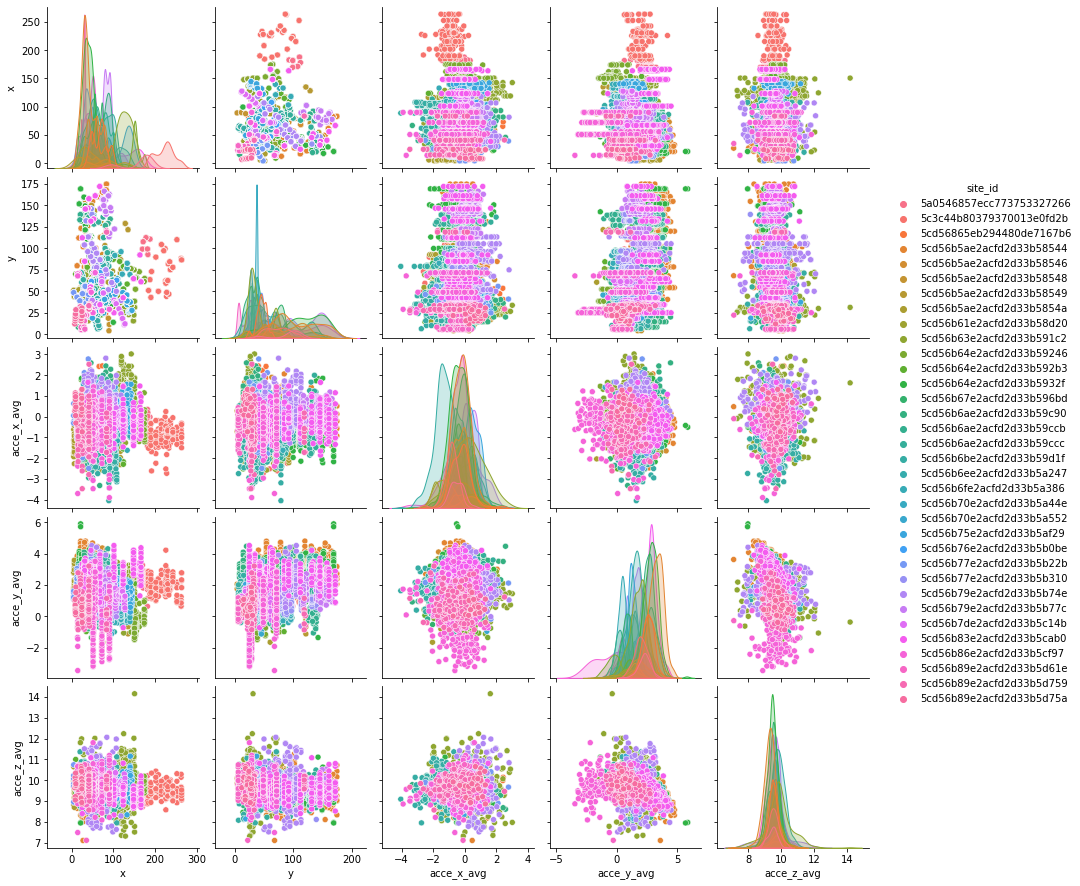

In [102]:
df_train_pp = df_train.loc[:, ["site_id", "x", "y", "acce_x_avg", "acce_y_avg", "acce_z_avg"]]
display(df_train_pp.head())
sns.pairplot(df_train_pp, hue="site_id")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


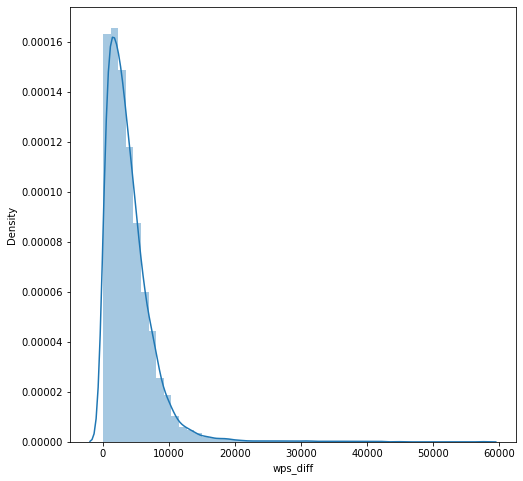

In [103]:
# Check the wps_diff distribution
# Need to filter out those wps that are above 5000ms difference from wifi_ts
f, ax = plt.subplots(figsize=(8, 8))
f.patch.set_facecolor("white")
sns.distplot(df_train["wps_diff"])
plt.show()

In [104]:
df_train_slim = df_train[df_train["wps_diff"] < WPS_CUT]
perc = round(len(df_train_slim)/len(df_train)*100, 2)

print("no of records: ", len(df_train))
print(f"Filter df_train with {WPS_CUT}, it retains {perc} % of data")

no of records:  7074
Filter df_train with 5000, it retains 72.43 % of data


In [106]:
# Visualizing timestamp distribution

# LabelEncode site_id, file_id, floor_converted, ssid, bssid
# def col_encode(df, cols):
#     for col in cols:
#         le = preprocessing.LabelEncoder()
#         df["%s_le"%col] = le.fit_transform(df[col])

# col_enc = ["site_id", "file_id", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
# col_encode(df_train, tqdm(col_enc))

# convert data types of certain columns
def convert_dtypes(df, col_list, dtype):
    for col in col_list:
        df[col] = df[col].astype(dtype)

convert_dtypes(df_train, tqdm(["wifi_ts"]), int)
convert_dtypes(df_train, tqdm(["file_id", "site_id", "floor"]), "category")

# Check
display(df_train.head())

100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


1,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,463ec9948b44589dfe1c3f3d1ad8d923cbcbb4ef,ea4208f40a36b18be923fcd5adb59b250d9cef96,0ae129da9fb6e90b624d53a7e34a3edbb0a7244b,06e02065793833706e3045b5c5a0b7c645ec76b2,cad4a88efef2989c5b08969bdf826f055c33b1b4,2caf39807897e4577f271ec67e5701eb36101b2c,ea950fdfe174caa330ad082bc5099fda7bc8a236,32ad7772f626e6d531c1de47806b68af6f33c339,29fbb6e4c43ceca86657bd242fd67eb5b97b97ba,2aaf2ffd96ed70b9b9061cee68fe2df8150db3e3,16f784df42e07d8bb8cf954e768166f988b6ca80,f65804069553e141a96eae17f475584617a5324b,4cff1c8cfec27801ddc9a690ade87c57f1142ee0,1a11be1c59c0057a3468722ca654f596fc846f7f,cbab1d8c6eb34917dc210c44430e58c283013de8,c79035b2f27644be5bd748bff59297f28803fae1,c70e999e91f2381a2856197df91987412d6e049e,86bd6179355aaeb54bcd541040f23808d6656442,e85bfadc24ead00bb0d80a56a2b24f5baee7da4a,0e5a262402b8c9d98a3b5a424863f6a6c655ab98,32bbd941505866b701812d1a5396315fc1af7f81,38f586d6a54a75a4fc9df0325de877b2bce5de6b,306a5e55e5d9d2c2425b1be8928e28b2d14ffc9d,14bc29d59e0046cc7d5ce53054f702da18f37c53,4869fc196d482be16a5f1867b3036d18c0a6436c,e8af39b7dfe78bd5413b4af4a667d052e8cbaa77,b369a53308605593bfdb343e867ba8e6655f1fe2,8d62c359632fdd988c4eedc2392fa2fec0dc2f22,584f44ed88f51e7ecf3c550df2301db3166a5aa1,688a2ecf1f543651ec563d2c397b137baf8d39ea,8b3c0b4adecdc3281c15a824690f5bdf8563ad82,028a310e23177c3747d37971678dd964ee28ce17,d7e9b02e68a4625a7ace5decdcaf4013a40eb1dd,d363ebdcc60c21f4a1ba386399be4ecac077b4ab,a4e52e503b6edc041739f3e68addff5bdf047b6b,e9a36465c8bf96c677d9d4831c585659c3c55909,6a620eb3b709557db95591f6d22ba6a06754f606,a929157f3cc32a433b02ad7d7876e9a1678d3944,85e6e3acc4f0005b00f70931e3f268bdf650956c,...,d2dd387663705a7b02c6a187478e42f124fc3ec7,fc6ac34a09929ca61f5a7338dc390de9c2d725d3,ae5dc76e42b87963bdaf90d4d71bfe8e2497d9a9,90c080b08abeb75fca39e9a9c7e6882810fd8f81,24bc09f2d8bf2adcd81cabcbd1b1f37fb74c9942,896f2eceb37af2807b28881abbd8e1ad86d9c575,1cdbd0367bce6b7df8e9d0fd6a7e0cc5173ab41b,762101750076cd380cb5ba1b7762a50c26aa17b4,8a3e1b9d9f7d77ac5c74752cfddd63f03af8e89f,f915d902742026b5be023871f8a72611dfa8968d,a879a2796c04cd328b6a6cfc544c81eeee2a31a5,d692db3c38747e883581759cc02f986abe769d17,64923b66eed4059b0ad72ab7f5999bfc9087afa1,39c893822c1e09a56f979a0c9f0429b9495ab351,9f25847505aa2b404960f504e1ef8347b95fc899,48a7665c915c79a77b082f981bc13a7a7bda2fd0,f364fba789d948e0597337e9dc48fee6eb8d6ad9,e149d47d3d2a0c31aff9bb53eb4886a9773e687e,48480327cc71f4b28f9ab03d2ae2902136603193,7a06a1ade97615325ff72816a924be6ec235df5a,5e4e20c60f12054e9df2706d204bf0cfe75fb12f,08e80b26da1a4c74e964cdf8e66659e62c1a4ed6,8a956d0ae53327c20ab6e412f028c40e1966d08b,ebabfd80de01f73434d042d8aab6be19243137a4,a7597a83ab9fed00f32c500f1f928df50bdadce8,af89ab7e9f486fdca5531f356ddb2c1e725f7204,c030de9c8d89af1d5046fa76f345a218c72901f0,de342b1ae0832f1ceeeae3ff979d34cc2d5c83c4,b9f6110e264e36b32f3060d7431b9adb775cff70,bc021d660b6a8a915383ce04128530ec990f70a6,6dd58a41783565e289996d440129be6d2dc7b14f,10aee5c40852b5c38371fd3c476d24ffb1c82227,cea877c992574e7acd97550fb8b2a27589d6f6fc,5a89287f6575df61ffbd0a0885e6d6281e8fa40d,43463bf8718a4e4eaf0e768024f95e32b360d51d,ae747a8f11ff030cb25de0bb0da00e57e911cdd0,db8c623f1a5207ea7cfc190b317a7e7dde00aed9,7acf672b5c8994c9d896fefffb5eff8aa9b24f12,db90ba7b9427d39ec470a05ac7e90daa29f0992b,8ac6be1dbc7130619fda422e1dbd5d61aac81f67,30ea98e73f40d8b8ac407300afe5a6036768641d,cbfe12ddaeb927214d146760cb6dfea416827cc6,0914d4c7a22438e1695c1943173fb762dca3d1e2,6848865fce448c98225181065294b997ce9ae1ee,5318389e0f2de363a8f3cf1077be4932b5c13617,3e4955d9939c985854b98179cb7d89eb18185f6d,9693596e0b358daa069da12e8c62817205967588,c8dc2a337edb798456669ad39feed0ef9b0f494f,site_id_le,file_id_le
2,1561450512731,2008,181.6933,99.36647,F4,3,5d11dc0cffe23f0008604f5b,5a0546857ecc773753327266,-0.756278,0.634557,9.925879,-50,-51,-55,-55,-55,-56,-56,-57,-57,-57,-57,-58,-58,-58,-58,-59,-59,-59,-59,-60,-60,-60,-60,-61,-61,-61,-61,-61,-61,-62,-62,-62,-63,-63,-63,-63,-63,-63,-64,...,-999,-999,-999,-999,-999,-999,-999,-9

In [108]:
print(df_train.iloc[:,:50].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7074 entries, 2 to 2
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   wifi_ts                                   7074 non-null   int64   
 1   wps_diff                                  7074 non-null   int64   
 2   x                                         7074 non-null   float64 
 3   y                                         7074 non-null   float64 
 4   floor                                     7074 non-null   category
 5   floor_int                                 7074 non-null   int64   
 6   file_id                                   7074 non-null   category
 7   site_id                                   7074 non-null   category
 8   acce_x_avg                                7074 non-null   float64 
 9   acce_y_avg                                7074 non-null   float64 
 10  acce_z_avg                 

In [68]:
# # Methods for preprocessing train data: Timestamp handling
# def find_diff_ts(ts, data):
#     data_ts = data[0]
#     diff_ts = int(data_ts) - int(ts)
#     return diff_ts

# def find_start_ts(path):
#     with open(path, 'r', encoding='utf-8') as file:
#         lines = file.readlines()

#     for line_data in lines:
#         line_data = line_data.strip()
#         m = re.search(r"(?<=startTime.)(.*)", line_data)
#         start_ts = m.groups(0)
#         if m:
#             return (start_ts[0])

# def find_smallest_diff(t, data):
#     if data.size == 0:
#         return np.array([])
#     else:
#         data_ts = data[:, [0]]
#         diff = []
#         for ts in data_ts:
#             diff.append(abs(int(t) - int(ts)))
#         closest_index = np.argmin(diff) # if multiple records have the same value..?
#         return data[closest_index]

In [ ]:
# # Method for preprocessing train data: splitting acce/ahrs/gyro/magn
# def split_axis(data, start_ts):
#     if data.size == 0:
#         # print("no axis data")
#         return [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
#     else:
#         data_ts = data[0]
#         diff_ts = int(data[0]) - int(start_ts)
#         x_axis = data[1]
#         y_axis = data[2]
#         z_axis = data[3]
#         try:
#             accuracy = data[4]
#         except IndexError:
#             accuracy = np.nan
#         return [data_ts, diff_ts, x_axis, y_axis, z_axis, accuracy]

# # Method for preprocessing train data: splitting wifi
# def split_wifi(data, start_ts):
#     if data.size == 0:
#         # print("no wifi data")
#         return [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
#     else:
#         data_ts = data[0]
#         diff_ts = int(data[0]) - int(start_ts)
#         ssid = data[1]
#         bssid = data[2]
#         rssi = data[3]
#         if len(data) > 5:
#             freq = data[4]
#             last_seen_ts = data[5]
#         else:
#             freq = np.nan
#             last_seen_ts = data[-1]
#         return [data_ts, diff_ts, ssid, bssid, rssi, freq, last_seen_ts]

# # Method for preprocessing train data: splitting ibeacon
# def split_beacon(data, start_ts):
#     if data.size == 0:
#         # print("no beacon data")
#         return [np.nan, np.nan, np.nan, np.nan]
#     else:
#         data_ts = data[0]
#         diff_ts = int(data[0]) - int(start_ts)
#         ssid = data[1]
#         rssi = data[2]
#         return [data_ts, diff_ts, ssid, rssi]

# # Method for preprocessing train data: calc rel pos
# def split_rel_pos(data, start_ts):
#     if data.size == 0:
#         # print("no rel_pos data")
#         return [np.nan, np.nan, np.nan, np.nan]
#     else:
#         data_ts = data[0]
#         diff_ts = int(data[0]) - int(start_ts)
#         x_axis = data[1]
#         y_axis = data[2]
#         return [data_ts, diff_ts, x_axis, y_axis]

In [ ]:
# # Extract path and other data
# def extract_path(path, floor_map):
#     # split path
#     try:
#         ex_path = f"{path}"
#         ex_paths = ex_path.split("/")
#         site_id = ex_paths[4]
#         floor = ex_paths[5]
#         f = floor_map[floor]
#         file_id = ex_paths[6].split(".")[0]
#         return [site_id, file_id, f, floor]
#     except:
#         print("extract_path error")

# # Definitely needs to be refactored
# def extract_data(path):
#     start_ts = find_start_ts(path)
#     path_datas = read_data_file(path)
#     acce = path_datas.acce
#     ahrs = path_datas.ahrs
#     magn = path_datas.magn
#     gyro = path_datas.gyro
#     acce_uncali = path_datas.acce_uncali
#     magn_uncali = path_datas.magn_uncali
#     gyro_uncali = path_datas.gyro_uncali
#     wifi = path_datas.wifi
#     wps = path_datas.waypoint
#     ibeacon = path_datas.ibeacon
#     rel_positions = calc_rel_positions(acce, ahrs)

#     # Changed from: just extracting wps time stamps -> take all acce uncalib timestamps
#     # ts = np.unique(wps[:, [0]])
#     if acce_uncali.any():
#         # print("acce_uncali")
#         ts = np.unique(acce_uncali[:, [0]]) # take uncalibrated access, as sometimes access has less data
#     elif acce.any():
#         # print("acce")
#         ts = np.unique(acce[:, [0]])
#     else:
#         print("no acce or acce_uncali")

#     # extract data for each timestamp of waypoints
#     res = []
#     for t in ts:
#         try:
#             wp_closest = find_smallest_diff(t, wps)
#             closest_wp_ts = wp_closest[0]
#             diff_ts_wp_ts = abs(int(t) - int(closest_wp_ts))
#             # time_stamp_cut = 2000, only the records within 2 sec of waypoint are kept
#             if diff_ts_wp_ts < time_stamp_cut:
#                 # flag to indicate how close the data point is to the wps
#                 # print("diff_ts_wp_ts", diff_ts_wp_ts)
#                 within_100ms = True if abs(diff_ts_wp_ts) <= 100 else False
#                 within_200ms = True if abs(diff_ts_wp_ts) <= 200 else False
#                 x = wp_closest[1]
#                 y = wp_closest[2]
#                 # print("x, y: ", x, y)
#                 diff_start_ts = int(t) - int(start_ts)
#                 diff_start_wp_ts = int(closest_wp_ts) - int(start_ts)
#                 # print("diff_start_ts, diff_start_wp_ts: ", diff_start_ts, diff_start_wp_ts)
#                 acce_closest = split_axis(find_smallest_diff(t, acce), start_ts)
#                 ahrs_closest = split_axis(find_smallest_diff(t, ahrs), start_ts)
#                 magn_closest = split_axis(find_smallest_diff(t, magn), start_ts)
#                 magn_closest.append(extract_one_magn_strength(magn_closest)) # append magnetic strength only for the magn data
#                 gyro_closest = split_axis(find_smallest_diff(t, gyro), start_ts)
#                 # print("acce: ", acce_closest)
#                 # print("ahrs: ", ahrs_closest)
#                 # print("magn: ", magn_closest)
#                 # print("gyro: ", gyro_closest)
#                 acce_u_closest = split_axis(find_smallest_diff(t, acce_uncali), start_ts)
#                 magn_u_closest = split_axis(find_smallest_diff(t, magn_uncali), start_ts)
#                 gyro_u_closest = split_axis(find_smallest_diff(t, gyro_uncali), start_ts)
#                 # print("acce_u_closest: ", acce_u_closest)
#                 # print("magn_u_closest: ", magn_u_closest)
#                 # print("gyro_u_closest: ", gyro_u_closest)
#                 wifi_closest = split_wifi(find_smallest_diff(t, wifi), start_ts)
#                 if len(ibeacon) > 0:
#                     beacon_closest = split_beacon(find_smallest_diff(t, ibeacon), start_ts)
#                 else:
#                     beacon_closest = [np.nan, np.nan, np.nan, np.nan]
#                 rel_pos = split_rel_pos(find_smallest_diff(t, rel_positions), start_ts)
#                 # print([t, x, y, int(closest_wp_ts), acce_closest, acce_u_closest])
#                 res.append([int(t), start_ts, diff_start_ts, x, y, int(closest_wp_ts), diff_start_wp_ts, diff_ts_wp_ts, within_100ms, within_200ms] + \
#                            acce_closest + ahrs_closest + magn_closest + gyro_closest + \
#                            acce_u_closest + magn_u_closest + gyro_u_closest + \
#                            wifi_closest + beacon_closest + rel_pos
#                           )
#             else:
#                 # print("no wp made it through timestamp cut")
#                 continue
#         except Exception as exc:
#             pass
#             # print("Error message: ", exc)
#             # print("extract_test_data error")
#     return res

In [ ]:
# # %%timeit

# # 5.55 ms ± 1.76 ms per loop
# path, site, floorNo, floor_plan_filename, \
# json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)

# def one_trace_to_rows(path, floor_map):
#     try:
#         path_info = extract_path(path, floor_map)
#         data = extract_data(path)
#         # rows = list(itertools.chain(path_info, *data))
#         rows = []
#         for d in data:
#             row = path_info + d
#             rows.append(row)
#             # print("row: ", row)
#         return rows
#     except:
#         print("one_trace_to_rows error at: ", path)

# # path -> train/5cd56bdbe2acfd2d33b663c0/L3/5dfc8108241c3600064049b9.txt
# # time w/ for loop with 1 train_path -> 11.6
# # time w/ itertools.chain for 1 train_path -> 11.8
# start = time.time()
# path_info = extract_path(path, floor_map)
# print("path: ", path_info)
# rows = one_trace_to_rows(path, floor_map)
# print("time to process one train_path", time.time() - start)
# #print("col count: ", len(rows[0]))
# print("rows: ", rows)

In [ ]:
# # Run row making function for all training paths
# # print(train_paths[:10])
# import time
# start = time.time()

# all_rows = []
# for train_path in train_paths[:10]:
#     rows = one_trace_to_rows(train_path, floor_map)
#     all_rows.extend(rows)

# one_trace_df = pd.DataFrame(all_rows)
# display(len(one_trace_df))

# # Data below are the time it took to create the old version of training data (only waypoints)
# # without Pool
# # 10 -> 1.64 sec
# # 100 -> 28.12 sec
# # 1000 -> 286.67 sec
# # to process training (~26,000 files) -> ~7500 sec (~2hours)
# print(time.time() - start)

# with Pool
# no need for wrapper with pool.starmap -> https://qiita.com/okiyuki99/items/a54797cb44eb4ae571f6

# Memo about Pool
# with Pool
# 10 -> 1.09 sec
# 100 -> 12.35 sec
# 1000 -> 113.87 sec
# to process training (~26,000 files) -> ~3000 sec (~50min)

In [ ]:
# # Check if we can make df

# # column names
# col_names = ["site_id", "file_id", "floor_converted", "floor", \
#              "ts", "start_ts", "diff_start_ts", "x", "y", \
#              "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", "within_100ms", "within_200ms", \
#              "acce_ts", "diff_acce_ts", "acce_x", "acce_y", "acce_z", "acce_acc", \
#              "ahrs_ts", "diff_ahrs_ts", "ahrs_x", "ahrs_y", "ahrs_z", "ahrs_acc", \
#              "magn_ts", "diff_magn_ts", "magn_x", "magn_y", "magn_z", "magn_acc", "magn_strength",\
#              "gyro_ts", "diff_gyro_ts", "gyro_x", "gyro_y", "gyro_z", "gyro_acc", \
#              "acce_u_ts", "diff_acce_u_ts", "acce_u_x", "acce_u_y", "acce_u_z", "acce_u_acc", \
#              "magn_u_ts", "diff_magn_u_ts", "magn_u_x", "magn_u_y", "magn_u_z", "magn_u_acc", \
#              "gyro_u_ts", "diff_gyro_u_ts", "gyro_u_x", "gyro_u_y", "gyro_u_z", "gyro_u_acc", \
#              "wifi_ts", "diff_wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
#              "beacon_ts", "diff_beacon_ts", "beacon_ssid", "beacon_rssi", \
#              "rel_ts", "diff_rel_ts", "rel_x", "rel_y"
#             ]

# print(len(col_names))

# df = pd.DataFrame(rows, columns=col_names)
# print("df len: ", len(df))
# print("site_id nunique: ", df["site_id"].nunique())
# print("file_id nunique: ", df["file_id"].nunique())
# print("x value_counts: ", df["x"].value_counts())
# print("y value_counts: ", df["y"].value_counts())
# print("event ts nunique: ", df["ts"].nunique())
# print("start ts nunique: ", df["start_ts"].nunique()) # should be one
# print("diff_ts_wp_ts value_counts: ", df["diff_ts_wp_ts"].value_counts())
# print("diff_ts_wp_ts nunique: ", df["diff_ts_wp_ts"].nunique())
# print("within_100ms value_counts: ", df["within_100ms"].value_counts())
# print("within_100ms nunique: ", df["within_100ms"].nunique())
# print("within_100ms count: ", df["within_100ms"].count())
# print("within_200ms value_counts: ", df["within_200ms"].value_counts())
# print("within_200ms nunique: ", df["within_200ms"].nunique())
# print("within_200ms count: ", df["within_200ms"].count())
# display(df.head())

In [ ]:
# # Set pool
# num_cores = multiprocessing.cpu_count()
# print(f"num_cores={num_cores}")
# # args = [(p, floor_map) for p in train_paths[:train_num]]
# args = [(p, floor_map) for p in grouped_paths_list]
# pool = Pool(num_cores)

# start = time.time()
# # w/ 250ms settings, 3 random samples from each site_id
# # 2 paths -> 18.7 sec
# # 10 paths -> 315 sec (df len is 1994)
# # 100 paths -> 708 sec (df len is 7183)
# # all ~ 600 paths -> 

# # errors
# # grouped_paths_list -> 100 paths -> site_id: 8 errors, 27 correct
# # grouped_paths_list -> 100 paths -> file_id: 23 errors, 77 correct

# # all in one go -> xxx sec
# # array_split -> 5891.8 sec

# # all in one go
# # res = pool.starmap(one_trace_to_rows, args)

# # split the args
# res = []
# for arg in tqdm(np.array_split(args, 50)):
#     res.extend(pool.starmap(one_trace_to_rows, arg))

In [ ]:
############################## KEEP THIS CELL FOR LATER REF ##############################

# Error in ~20% of the train paths -> caused by not having acces_uncali to create the event timestamps

# error files
# /5cd56b5ae2acfd2d33b58548/1F/5cf20b29718b08000848aa0a.txt
# /5cd56b5ae2acfd2d33b58548/2F/5cf214bbc852a70008c01607.txt
# /5cd56b5ae2acfd2d33b58548/2F/5cf214bda50dc300099d34cc.txt
# /5cd56b61e2acfd2d33b58d20/F2/5d085df529994a0008202661.txt
# /5cd56b61e2acfd2d33b58d20/F2/5d085dea4a2bd40008d47468.txt
# /5cd56b61e2acfd2d33b58d20/F4/5d086c44d85da00008644fce.txt
# /5cd56b5ae2acfd2d33b5854a/F3/5d078bab0e86b60008036348.txt
# /5cd56b5ae2acfd2d33b5854a/B1/5d073ba64a19c000086c559b.txt
# /5cd56b5ae2acfd2d33b5854a/F1/5d07603e4cae4f000a2db525.txt
# /5cd56b63e2acfd2d33b591c2/F2/5d0b0668912a980009fe91f2.txt
# /5cd56b63e2acfd2d33b591c2/F1/5d0afbfb2f8a26000805b9cb.txt
# /5cd56b63e2acfd2d33b591c2/F1/5d0afbf92f8a26000805b9c9.txt
# /5cd56b64e2acfd2d33b592b3/F2/5d0c9321c99c56000836df18.txt
# /5cd56b64e2acfd2d33b592b3/F3/5d0c9952ea565d0008e34e8b.txt
# /5cd56b64e2acfd2d33b592b3/F4/5d0c9d65ea565d0008e34ea2.txt
# /5cd56b5ae2acfd2d33b58549/5F/5d0613514a19c000086c432a.txt
# /5cd56b5ae2acfd2d33b58549/2F/5d11a6089c50c70008fe89bc.txt
# /5cd56b79e2acfd2d33b5b74e/F3/5d0b01522f8a26000805ba3e.txt
# /5cd56b79e2acfd2d33b5b74e/F3/5d0b015e2f8a26000805ba44.txt
# /5cd56b79e2acfd2d33b5b74e/F1/5d0af3452f8a26000805b830.txt
# /5cd56b6be2acfd2d33b59d1f/F1/5d08a1545125450008037d87.txt
# /5cd56b6be2acfd2d33b59d1f/F1/5d08a14e3f461f0008dac56c.txt
# /5cd56b6be2acfd2d33b59d1f/F3/5d0896415125450008037c76.txt

# base_path = "../input/indoor-location-navigation/train"
# error_files = [
#     "/5cd56b5ae2acfd2d33b58548/1F/5cf20b29718b08000848aa0a.txt",
#     "/5cd56b61e2acfd2d33b58d20/F2/5d085dea4a2bd40008d47468.txt",
#     "/5cd56b61e2acfd2d33b58d20/F4/5d086c44d85da00008644fce.txt",
#     "/5cd56b5ae2acfd2d33b5854a/F3/5d078bab0e86b60008036348.txt",
#     "/5cd56b63e2acfd2d33b591c2/F1/5d0afbfb2f8a26000805b9cb.txt",
#     "/5cd56b63e2acfd2d33b591c2/F1/5d0afbf92f8a26000805b9c9.txt",
#     "/5cd56b5ae2acfd2d33b58549/2F/5d11a6089c50c70008fe89bc.txt",
#     "/5cd56b79e2acfd2d33b5b74e/F3/5d0b01522f8a26000805ba3e.txt",
#     "/5cd56b6be2acfd2d33b59d1f/F1/5d08a1545125450008037d87.txt",
#     "/5cd56b6be2acfd2d33b59d1f/F1/5d08a14e3f461f0008dac56c.txt"
# ]

# working_path = "../input/indoor-location-navigation/train/5d2709c303f801723c3299ee/1F/5dad7d6daa1d300006faa80c.txt"
# error_paths = [base_path + e for e in error_files]
# rows = one_trace_to_rows(error_paths[1], floor_map)
# print(rows)

In [ ]:
# start = time.time()

# df_train = pd.DataFrame(res[0], columns=col_names)
# for r in res[1:]:
#     df = pd.DataFrame(r, columns=col_names)
#     df_train = df_train.append(df, ignore_index=True)

# print("time to process", time.time() - start)
# print("length of df made", len(df_train))
# display(df_train.head(10))

In [ ]:
# def list_to_df(row_list):
#     df_train = pd.DataFrame(row_list[0], columns=col_names)
#     for r in row_list[1:]:
#         df = pd.DataFrame(r, columns=col_names)
#         df_train = df_train.append(df)
#     return df_train

# start = time.time()
# pool = Pool(num_cores)

# df_train = pool.map(list_to_df, tqdm(res))

# # print("train_path count", len(train_paths[:train_num]))
# print("time to process", time.time() - start)
# print("length of df made", len(df_train))
# display(df_train.head(10))
# pool.close()

In [ ]:
# Calculate moving averages
# Differencing respect to time (as each timestep is unevenly spaced)

In [ ]:
# # Save the file in parquet
# # https://www.kaggle.com/pedrocouto39/fast-reading-w-pickle-feather-parquet-jay
# # https://www.kaggle.com/prmohanty/python-how-to-save-and-load-ml-models

# # Saving train data
# train_file_name = "indoor_train_4.pkl"

# with open(train_file_name, "wb") as file:
#     pickle.dump(df_train, file)

# # Save them to output
# # df_train.to_csv('df_train_2.csv',index=False)
# # df_test.to_csv('df_test.csv',index=False)

In [ ]:
# # Load data it back in
# with open(train_file_name, "rb") as file:
#     df_train = pickle.load(file)

In [ ]:
# print("df len: ", len(df_train), "\n")
# print("file_id unique: ", (df_train["file_id"].nunique()), "\n")
# print("site_id unique: ", (df_train["site_id"].nunique()), "\n")
# print("site_id value_counts: ", (df_train["site_id"].value_counts()))
# display(df_train.head())

In [ ]:
# # Get submission file
# sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
# sub_df[["site", "file", "timestamp"]] = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
# sub_df = sub_df.drop(columns=["floor", "x", "y"])
# # grouped_df = sub_df.groupby("file").sample(n=2)
# # all_file_id = grouped_df["file"].unique()
# # print(len(grouped_df))
# # print(len(all_file_id))
# # display(grouped_df.head())
# display(sub_df.head())

# test_site_id = sub_df["site"].unique()
# train_site_id = df_train["site_id"].unique()
# print(test_site_id, "\n")
# print(train_site_id, "\n")
# a = list(set(test_site_id) & set(train_site_id))
# print(a)